In [1]:
%config Completer.use_jedi=False

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os.path
import csv
import seaborn as sns
import pandas as pd
import numpy as np
import argparse
import gzip
import pandas as pd
import textwrap



class DNA(object):
    dna_alphabet = set("AGCTN")

    def __init__(self, sequence):
        self.sequence = sequence.upper()

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, key):
        return self.sequence[key]

    def __hash__(self):
        return hash(self.sequence)

    def __repr__(self):
        return self.sequence

    def __eq__(self, other):
        return self.sequence == other.sequence


class SingleAlignment(object):
    def __init__(self, srna, position, strand, times_aligned, indv_alignments):
        self.srna = srna
        self.position = position
        self.strand = strand
        self.times_aligned = times_aligned
        self.indv_alignments = indv_alignments

    def srna_len(self):
        return len(self.srna)

    def standard_error(self): #TODO: check - likely don't neeed here
        return np.std(self.indv_alignments, ddof=1) / np.sqrt(
            np.size(self.indv_alignments)
        )

    def mean_alignments(self):
        return np.mean(self.indv_alignments)

    def __str__(self):
        return "{0}\t{1}\t{2}\t{3}\t{4}".format(
            self.srna,
            self.position,
            self.strand,
            self.times_aligned,
            self.indv_alignments,
        )

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return (
            self.srna == other.srna
            and self.position == other.position
            and self.strand == other.strand
            and self.times_aligned == other.times_aligned
            and np.array_equal(self.indv_alignments, other.indv_alignments)
        )


class SingleRefProfile(object):
    def __init__(self):
        self.ref_len = 0
        self.all_alignments = []

    def __str__(self):
        return "{0}\t{1}".format(self.ref_len, self.all_alignments)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return (
            self.ref_len == other.ref_len
            and self.all_alignments == other.all_alignments
        )


class RefProfiles(object):
    def __init__(self):
        self.srna_len = 0
        self.replicates = 0
        self.single_ref_profiles = {}

    def __str__(self):
        return "{0}\t{1}\t{2}".format(
            self.srna_len, self.replicates, self.single_ref_profiles
        )

    def __eq__(self, other):
        return (
            self.replicates == other.replicates
            and self.single_ref_profiles == other.single_ref_profiles
            and self.srna_len == other.srna_len
        )

    def load_single_ref_profiles(self, in_file):
        try:
            with open(in_file, "r") as in_handle:
                reader = csv.reader(in_handle, delimiter=",")
                for row in reader:
                    if row[0] == "Header":
                        continue
                    header = row[0]
                    ref_len = int(row[1])
                    srna = DNA(row[2])
                    position = int(row[3])
                    strand = row[4]
                    times_aligned = int(row[5])
                    indv_alignments = np.array([float(x) for x in row[6:]])
                    sa = SingleAlignment(
                        srna, position, strand, times_aligned, indv_alignments
                    )

                    if header not in self.single_ref_profiles:
                        self.single_ref_profiles[header] = SingleRefProfile()
                        self.single_ref_profiles[header].ref_len = ref_len
                        self.srna_len = len(srna)
                    self.single_ref_profiles[header].all_alignments.append(sa)

                self.replicates = len(sa.indv_alignments)
        except:
            print("\nEmpty or broken alignment file - skipping")

class DataForPlot(object):
    def __init__(self, ref_profiles, header):
        self.ref_profiles = ref_profiles
        self.header = header
        self.ref_len = ref_profiles.single_ref_profiles[header].ref_len
        self.srna_len = ref_profiles.srna_len
        self.replicates = ref_profiles.replicates
        self.fwd = np.zeros((self.ref_len + 1, self.replicates), dtype=float)
        self.rvs = np.zeros((self.ref_len + 1, self.replicates), dtype=float)
        self.x_axis = list(range(len(self.fwd)))
        self.y_flat = []
        self._extract_from_ref_profiles()
    
    def _extract_from_ref_profiles(self):
        for sa in self.ref_profiles.single_ref_profiles[self.header].all_alignments:
            if sa.strand == "+":
                self.fwd[sa.position] = sa.indv_alignments
            else:
                self.rvs[sa.position] = sa.indv_alignments

    def convert_to_coverage(self, abund=True):
        self.fwd = self._coverage_per_strand(self.fwd, abund)
        self.rvs = self._coverage_per_strand(self.rvs, abund)

    def _coverage_per_strand(self, old_array, abund): #TODO: Fix for better use of numpy
        new_arr= np.zeros((old_array.shape), dtype=float)
        for i in range(len(new_arr)-self.srna_len+1):
            for j in range(len(new_arr[i])):
                if not abund:
                    new_arr[i:i+self.srna_len, j]+=old_array[i,j]
                else:
                    for k in range(self.srna_len):
                        if old_array[i,j]>new_arr[i+k,j]:
                            new_arr[i+k,j]=old_array[i,j]
        return new_arr
    
    def convert_to_error_bounds(self): #TODO: document and test
        self.fwd = self._error_bounds(self.fwd)
        self.rvs = self._error_bounds(self.rvs)
    
    def _error_bounds(self, old_array, mean_only=True): #TODO: document and test
        new_arr= np.zeros((self.ref_len + 1, 2), dtype=float)
        for i in range(len(new_arr)):
            if mean_only:
                new_arr[i,0]=np.mean(old_array[i,:])
                new_arr[i,1]=np.mean(old_array[i,:])
            else:
                new_arr[i,0]=np.mean(old_array[i,:])-(np.std(old_array[i,:])/np.sqrt(self.replicates))
                new_arr[i,1]=np.mean(old_array[i,:])+(np.std(old_array[i,:])/np.sqrt(self.replicates))
        return new_arr        

    def flatten(self, d = 1):
        if d == 1:
            for i in range(self.fwd.shape[1]):
                self.y_flat.append(self.fwd[:,[i]].flatten())
                self.y_flat.append(-self.rvs[:,[i]].flatten())
        else:
            for i in range(self.fwd.shape[1]):
                self.y_flat.append(self._smoothTriangle(self.fwd[:,[i]].flatten(),d))
                self.y_flat.append(self._smoothTriangle(-self.rvs[:,[i]].flatten(),d))
    
    @staticmethod
    def _smoothTriangle(data, degree):
        triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
        smoothed=[]

        for i in range(degree, len(data) - degree * 2):
            point=data[i:i + len(triangle)] * triangle
            smoothed.append(np.sum(point)/np.sum(triangle))
        # Handle boundaries
        smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed #TODO: this can be better
        while len(smoothed) < len(data):
            smoothed.append(smoothed[-1])
        return smoothed   

    def __str__(self): 
        return "{0}\t{1}\t{2}\t{3}\t{4}".format(
            self.header, self.ref_len, self.srna_len, self.fwd, self.rvs,
        )

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other): 
        return (
            self.header == other.header
            and self.ref_len == other.ref_len
            and self.srna_len == other.srna_len
            and np.array_equal(self.fwd, other.fwd)
            and np.array_equal(self.rvs, other.rvs)
        )

def align_plot(align_prefix, align_lens, header, smoothing_window=1, cov = True, abund=True, se = True, save=True, ylim_set=(0,0), save_file=""):
    file_paths = []
    set_up_plot(ylim_set)
    for i in align_lens:
        file_paths.append("{0}_{1}.csv".format(align_prefix, i))
    for i in file_paths:
        if not os.path.isfile(i):
            pass
        else:
            rp = RefProfiles()
            rp.load_single_ref_profiles(i)
            single_plot(rp, header, smoothing_window, cov, abund, se)
    if se:
        plt.legend()
    if save:
        if save_file =="":
            save_file = align_prefix+"_"+header+".png"
        plt.savefig(save_file)
    plt.show()



def set_up_plot(ylim_set):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.xlabel("Position")
    plt.ylabel("Abundance")
    plt.title("Abundance Profile")
    if ylim_set!=(0,0):
        plt.ylim(ylim_set[0],ylim_set[1])
    


def single_plot(ref_profiles, header, smoothing_window, cov, abund, se):
    cols={24:'darkgreen', 21:'red', 22:'blue',
                  18:'#FFBA00', 19:'#9080ff', 20:'#984ea3',
                  23:"#f2eb0c", 24: "#edbf33", 25:"#cbd6e4", 26:"#bfcbdb", 27:"#b3bfd1", 28:"#a4a2a8"} #TODO: complete
    
    try:
        spd = DataForPlot(ref_profiles, header)
        plt.plot(spd.x_axis, [0]*len(spd.x_axis), color='grey',linewidth=0.5)
        if cov:
            if abund:
                spd.convert_to_coverage(abund=True)
            else:
                spd.convert_to_coverage(abund=False)
        if se:
            spd.convert_to_error_bounds()
            spd.flatten(smoothing_window)
            plt.fill_between(spd.x_axis, spd.y_flat[0], spd.y_flat[2], color=cols[spd.srna_len], alpha=0.5, linewidth=2,label=str(spd.srna_len)+" nt")
            plt.fill_between(spd.x_axis, spd.y_flat[1], spd.y_flat[3], color=cols[spd.srna_len], alpha=0.5, linewidth=2)
        else:
            spd.flatten(smoothing_window)
            first=True
            for i in range(spd.replicates):
                if first:
                    plt.plot(spd.x_axis, spd.y_flat[i], spd.y_flat[i+spd.replicates], color=cols[spd.srna_len], alpha=.8, label=str(spd.srna_len)+" nt")
                    first=False
                else:
                    plt.plot(spd.x_axis, spd.y_flat[i], spd.y_flat[i+spd.replicates], color=cols[spd.srna_len], alpha=.8)
                plt.fill_between(spd.x_axis, spd.y_flat[i], spd.y_flat[i+spd.replicates], color=cols[spd.srna_len], alpha=.05)
    except:
        pass

def comma_separated_ints(value):
    try:
        return [int(v) for v in value.split(',')]
    except ValueError:
        raise argparse.ArgumentTypeError("Invalid comma-separated integers: '{}'".format(value))



def count_siRNAs(total_files, trapr_files, save_file=0):
    x=[18,19,20,21,22,23,24,25,26,27,28,29,30]
    data=[]
    for read_file in total_files:
        norm = indv(read_file)
        for i in range(len(norm)):
            data.append([x[i],norm[i], "Total"])
    for read_file in trapr_files:
        norm = indv(read_file)
        for i in range(len(norm)):
            data.append([x[i],norm[i], "Trapr"])
    df = pd.DataFrame(data,columns = ['Size', 'Count', 'Purification'])
    sns.set_theme(style="white", rc={"lines.linewidth": 1}, palette=None)
    g = sns.catplot(data=df, x="Size", y='Count', hue='Purification', kind="point",errorbar="se", err_kws={'linewidth': 1}, capsize=0.1)
    if save_file!=0:   
        plt.savefig(save_file, dpi=300)
    plt.show()

def indv(read_file):
    counts = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    nextl=False
    with gzip.open(read_file, 'rt') as f:
        for line in f:
            if line[0]=="@":
                nextl=True
            elif nextl:
                line=line.strip()
                if len(line)<=30:
                    counts[len(line)-18]+=1
                nextl=False
    
    tot = sum(counts)
    print(read_file, tot)
    norm = [x*1000000/tot for x in counts]
    return norm


class RefSeq(dict):
    def load_ref_file(self, in_file):
        with open(in_file, 'r') as f:
            header = ""
            for line in f:
                line = line.strip()
                if line == "":
                    pass
                elif line[0] == ">":
                    header = line[1:]
                    self[header] = ""
                else:
                    self[header] += line

        f.close()
 
def merge_multiple_ref_profiles(ref_profiles_list):
    if not ref_profiles_list:
        raise ValueError("The list of RefProfiles is empty")

    base_ref_profiles = ref_profiles_list[0]

    for ref_profiles in ref_profiles_list[1:]:
        for header, single_ref_profile in ref_profiles.single_ref_profiles.items():
            if header not in base_ref_profiles.single_ref_profiles:
                base_ref_profiles.single_ref_profiles[header] = single_ref_profile
            else:
                base_single_ref_profile = base_ref_profiles.single_ref_profiles[header]
                for alignment in single_ref_profile.all_alignments:
                    matched = False
                    for base_alignment in base_single_ref_profile.all_alignments:
                        if base_alignment.position == alignment.position and base_alignment.strand == alignment.strand:
                            base_alignment.indv_alignments = base_alignment.indv_alignments + alignment.indv_alignments
                            matched = True
                            break
                    if not matched:
                        base_single_ref_profile.all_alignments.append(alignment)

    base_ref_profiles.srna_len = ref_profiles_list[0].srna_len  
    return base_ref_profiles   


def write_ref_profiles_to_csv(ref_profiles, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',')
        

        csv_writer.writerow(["Header","len","sRNA","Position","Strand","Times aligned","45-2_trapr.fq.gz","44-2_trapr.fq.gz","43-2_trapr.fq.gz"
])

        for header, single_ref_profile in ref_profiles.single_ref_profiles.items():
            for alignment in single_ref_profile.all_alignments:
                row = [
                    header,
                    single_ref_profile.ref_len,
                    str(alignment.srna),
                    alignment.position,
                    alignment.strand,
                    alignment.times_aligned
                ]
                row.extend(alignment.indv_alignments)
                csv_writer.writerow(row)

# Fig S8A

### Col dsGFP bot GFP input and trapr counts

brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_1.fq.gz 5193795
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_2.fq.gz 6664903
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_3.fq.gz 4644417
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_1.fq.gz 12768875
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_2.fq.gz 11046635
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_3.fq.gz 11289722


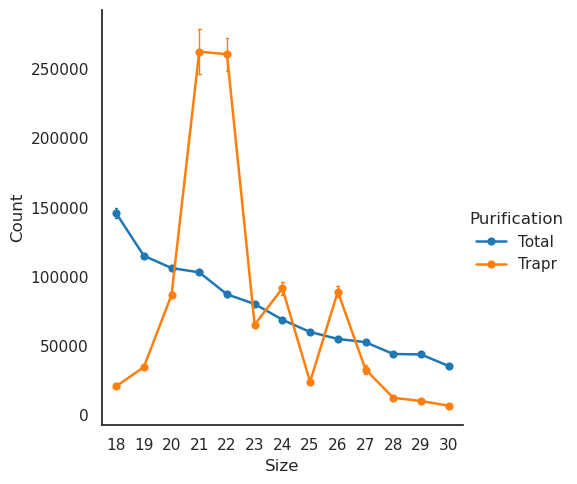

In [5]:
count_siRNAs(["brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_1.fq.gz",
              "brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_2.fq.gz",
              "brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_3.fq.gz"],
            ["brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_1.fq.gz",
             "brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_2.fq.gz",
             "brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_3.fq.gz"],
            "brosnan_et_al/figures/fig_S8A/col_dsGFP_bot_GFP_read_counts.png")

# Fig S8C

### Col dsGFP bot GFP input

In [9]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_1.fq.gz,brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_2.fq.gz,brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_3.fq.gz \
    -l 20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S8C/col_dsGFP_bot_gfp_input \
    -t fq --noSplit



Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_3.fq.gz - 4,987,388 reads processed
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_1.fq.gz - 5,543,332 reads processed
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_input_2.fq.gz - 7,110,753 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 3.749950807s


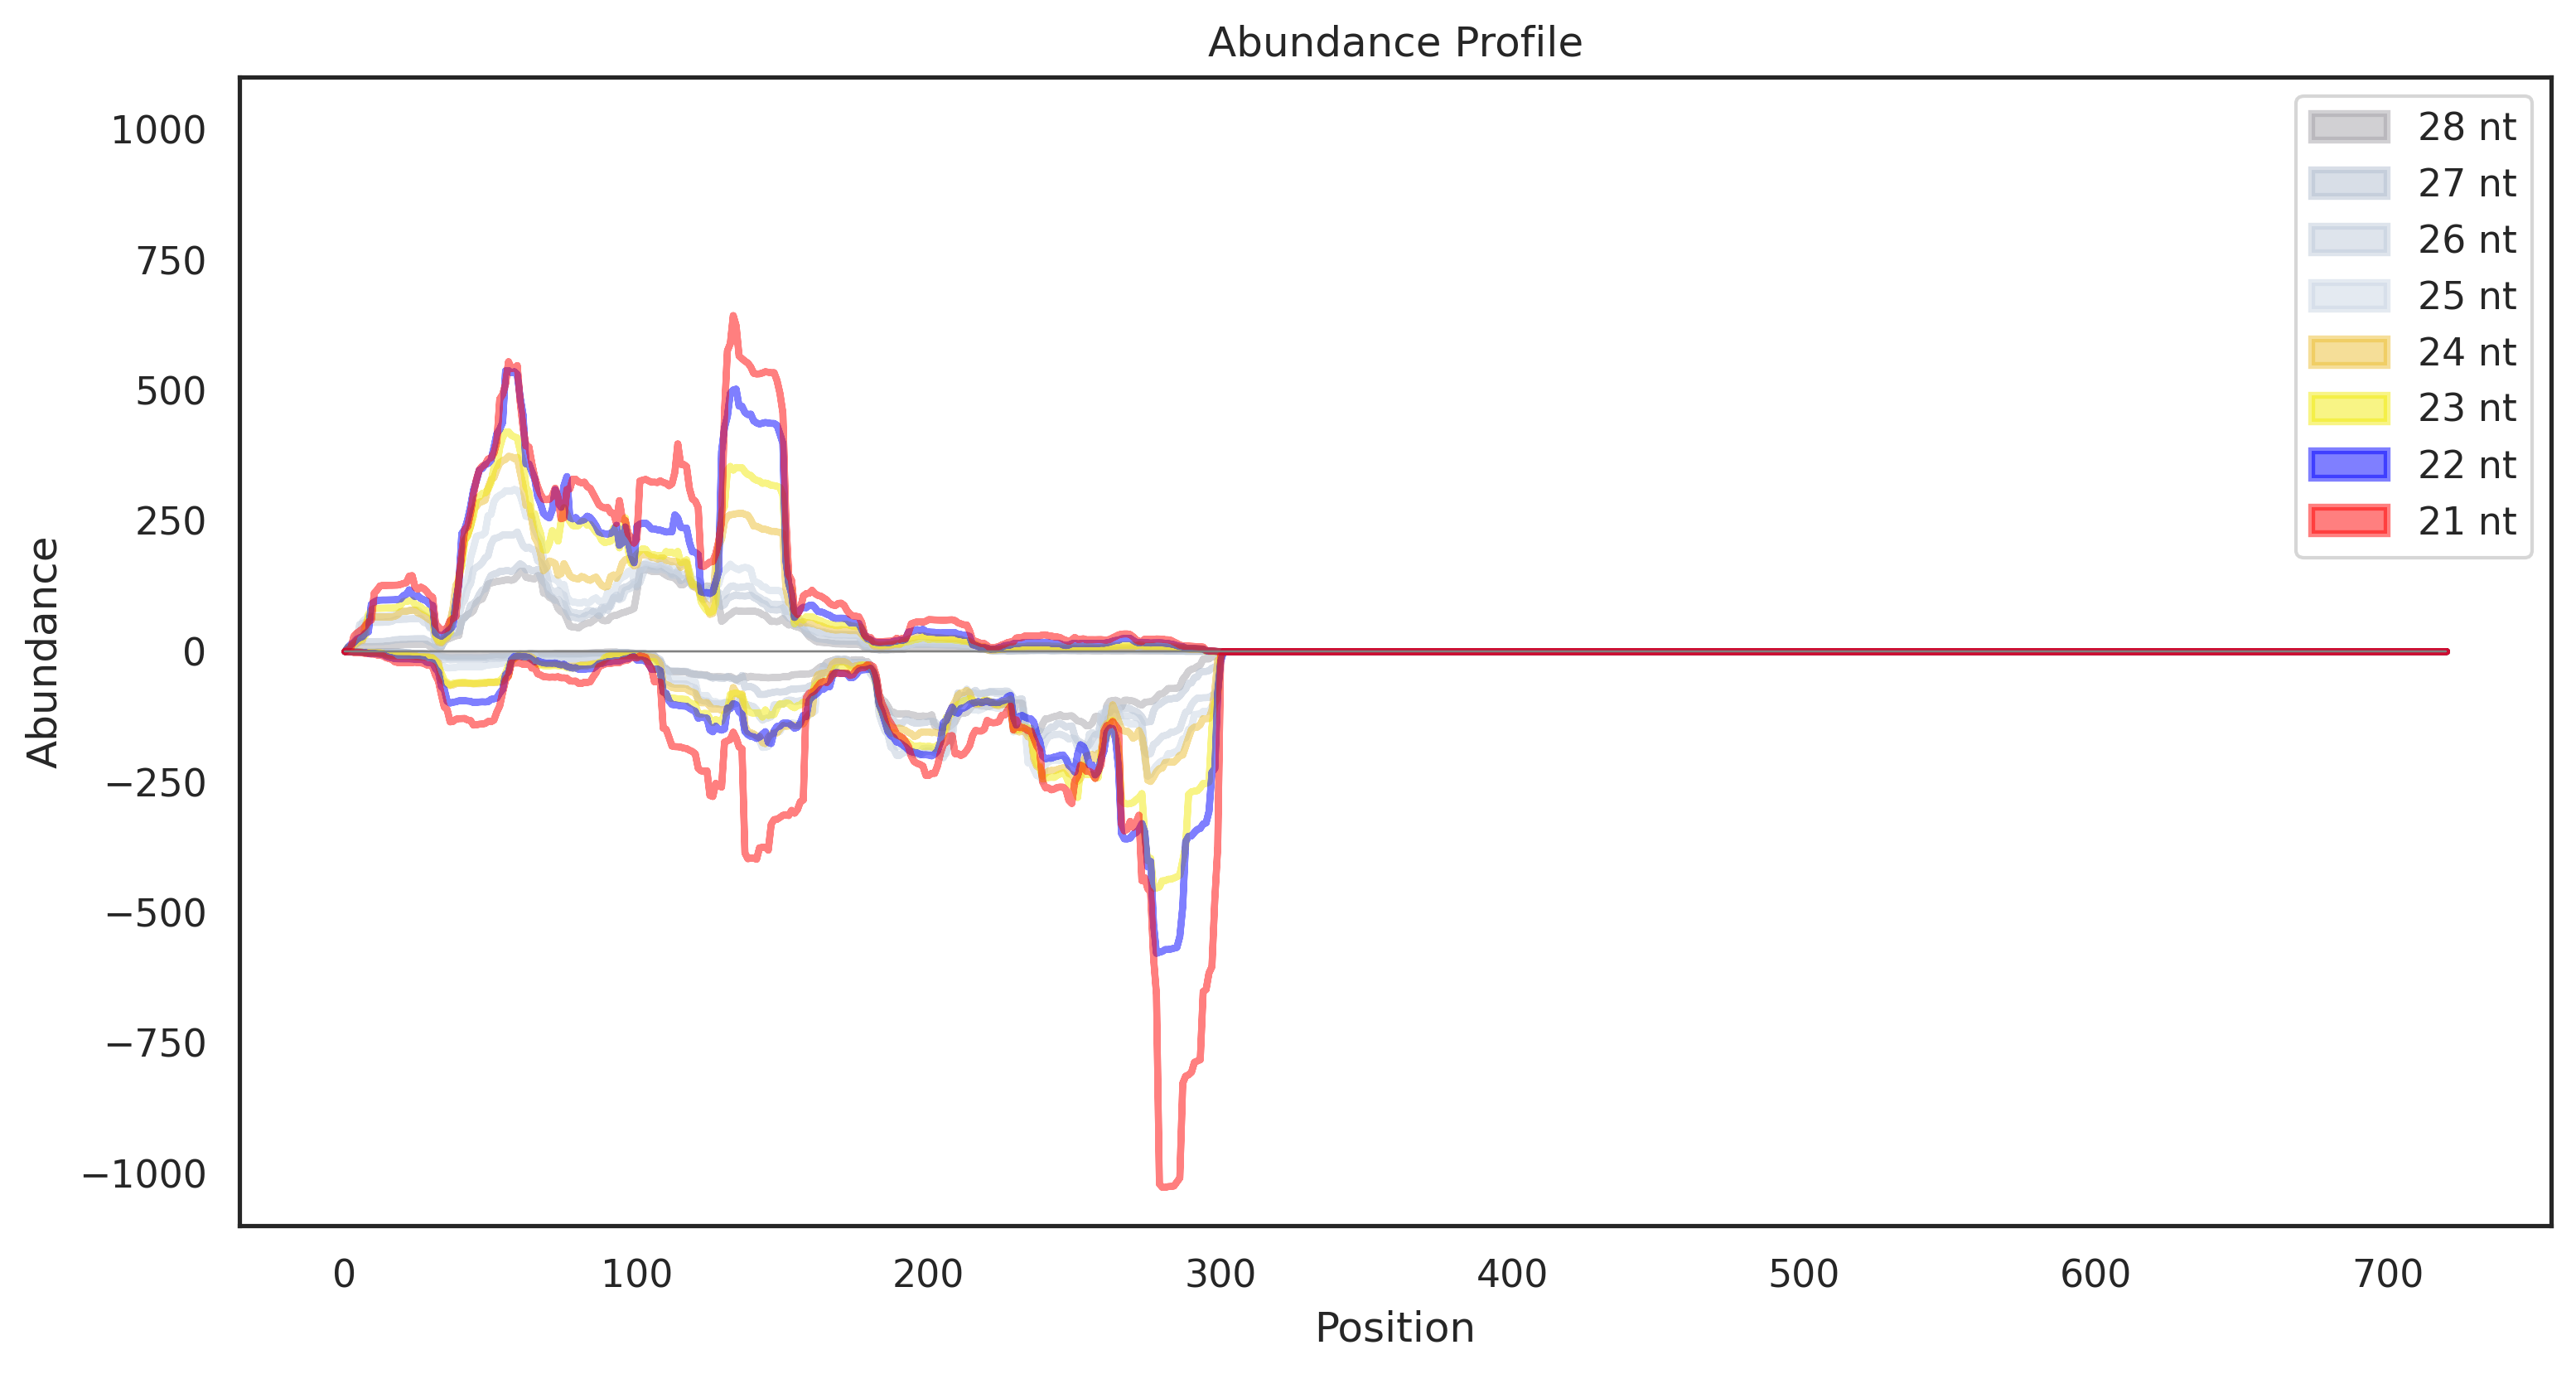

In [10]:
align_plot("brosnan_et_al/figures/fig_S8C/col_dsGFP_bot_gfp_input",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-1100,1100), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S8C/col_dsGFP_bot_gfp_input.png")


# Fig 5H

### Col dsGFP bot GFP trapr

In [11]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_1.fq.gz,brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_2.fq.gz,brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_5H/col_dsGFP_bot_gfp_trapr \
    -t fq --noSplit



Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_3.fq.gz - 11,436,540 reads processed
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_2.fq.gz - 11,189,040 reads processed
brosnan_et_al/reads/col_dsGFP_bot_GFP_input_trapr/col_dsGFP_bot_GFP_trapr_1.fq.gz - 12,955,427 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 4.660705402s


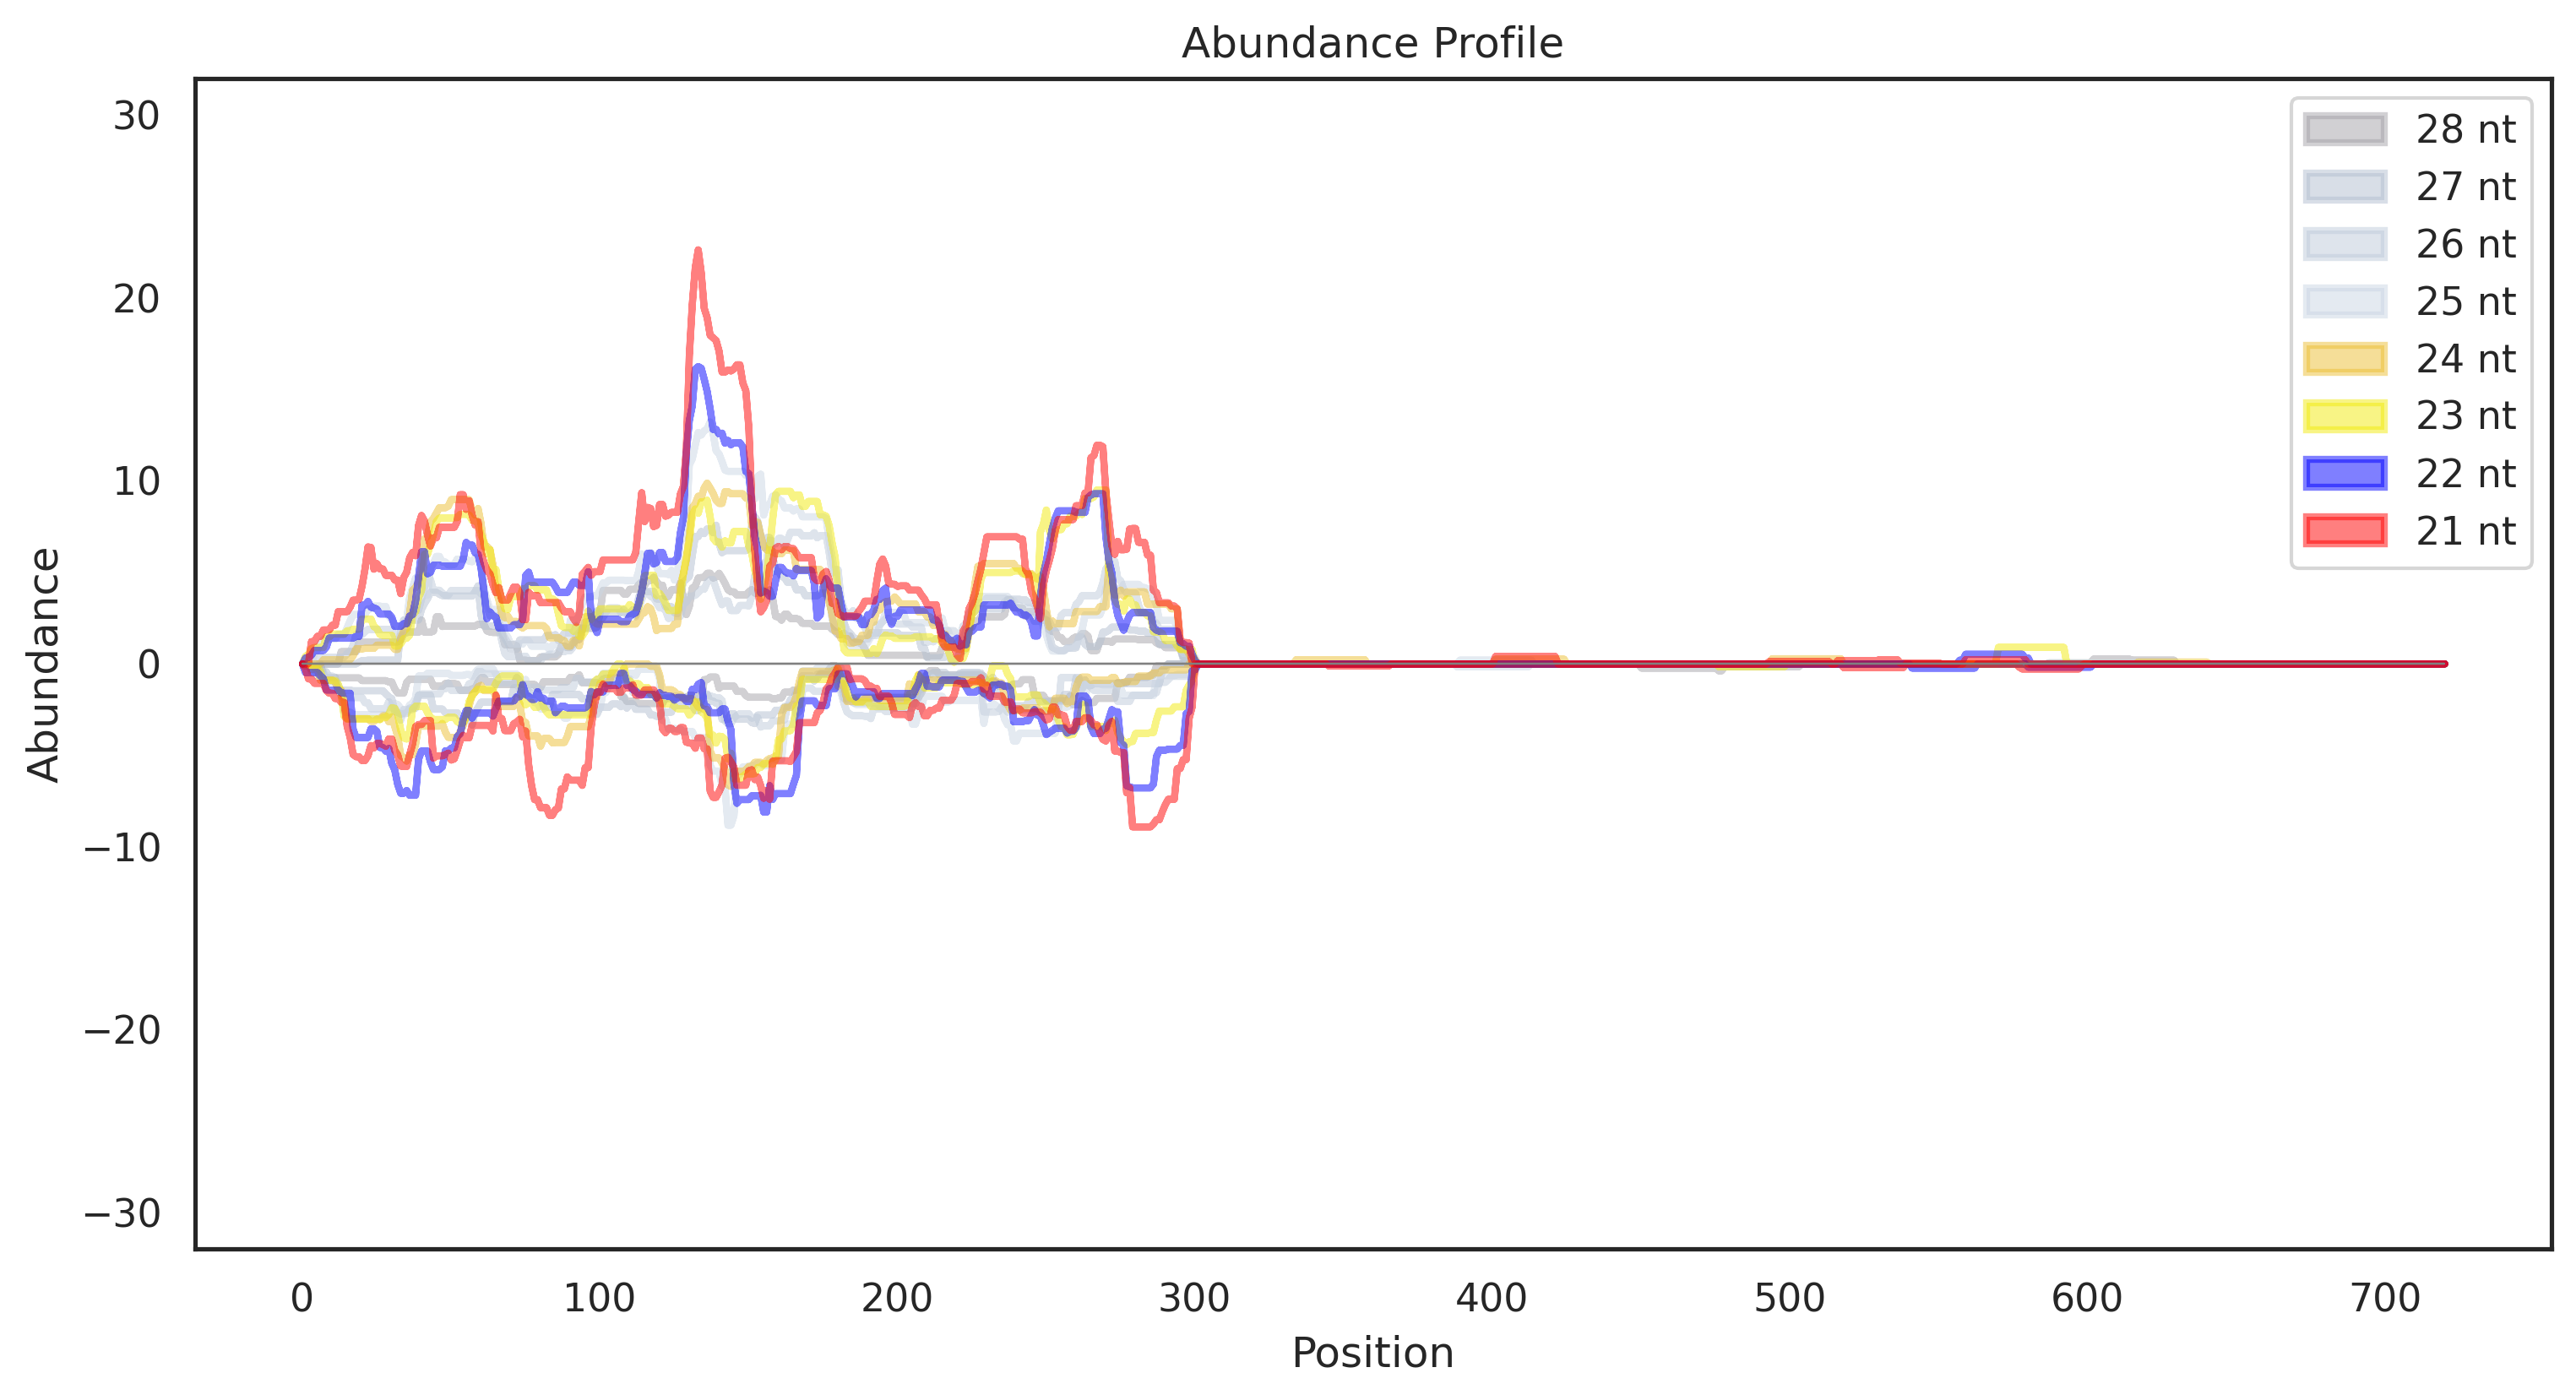

In [12]:
align_plot("brosnan_et_al/figures/fig_5H/col_dsGFP_bot_gfp_trapr",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-32,32), se=True, abund=False, save_file="brosnan_et_al/figures/fig_5H/col_dsGFP_bot_gfp_trapr_eGFP.png")

# Fig S8B

## 234 dsGFP bot GFP input and trapr counts

brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_1.fq.gz 4196702
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_2.fq.gz 3705370
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_3.fq.gz 5193627
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_1.fq.gz 7507299
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_2.fq.gz 7752462
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_3.fq.gz 11523410


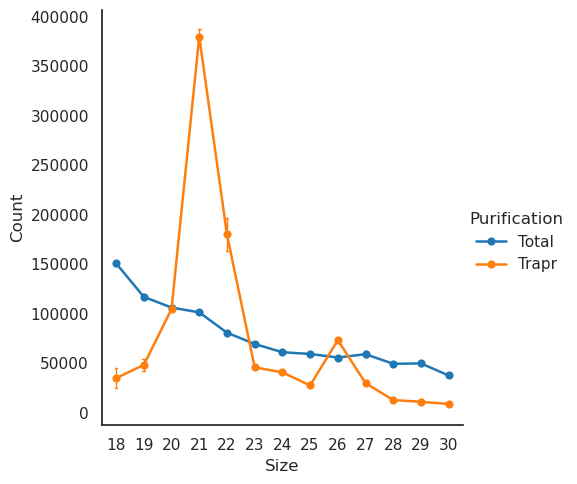

In [14]:
count_siRNAs(["brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_1.fq.gz",
              "brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_2.fq.gz",
              "brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_3.fq.gz"],
            ["brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_1.fq.gz",
             "brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_2.fq.gz",
             "brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_3.fq.gz"],
            "brosnan_et_al/figures/fig_S8B/234_dsGFP_bot_input_trapr.png")

# Fig S8D

## dcl234 dsGFP bot GFP input

In [15]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa\
    -1 brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_1.fq.gz,brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_2.fq.gz,brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_3.fq.gz \
    -l 20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S8D/dcl234_dsGFP_bot_gfp_input \
    -t fq 


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_2.fq.gz - 3,943,944 reads processed
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_1.fq.gz - 4,505,082 reads processed
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_input_3.fq.gz - 5,548,979 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 3.089691393s


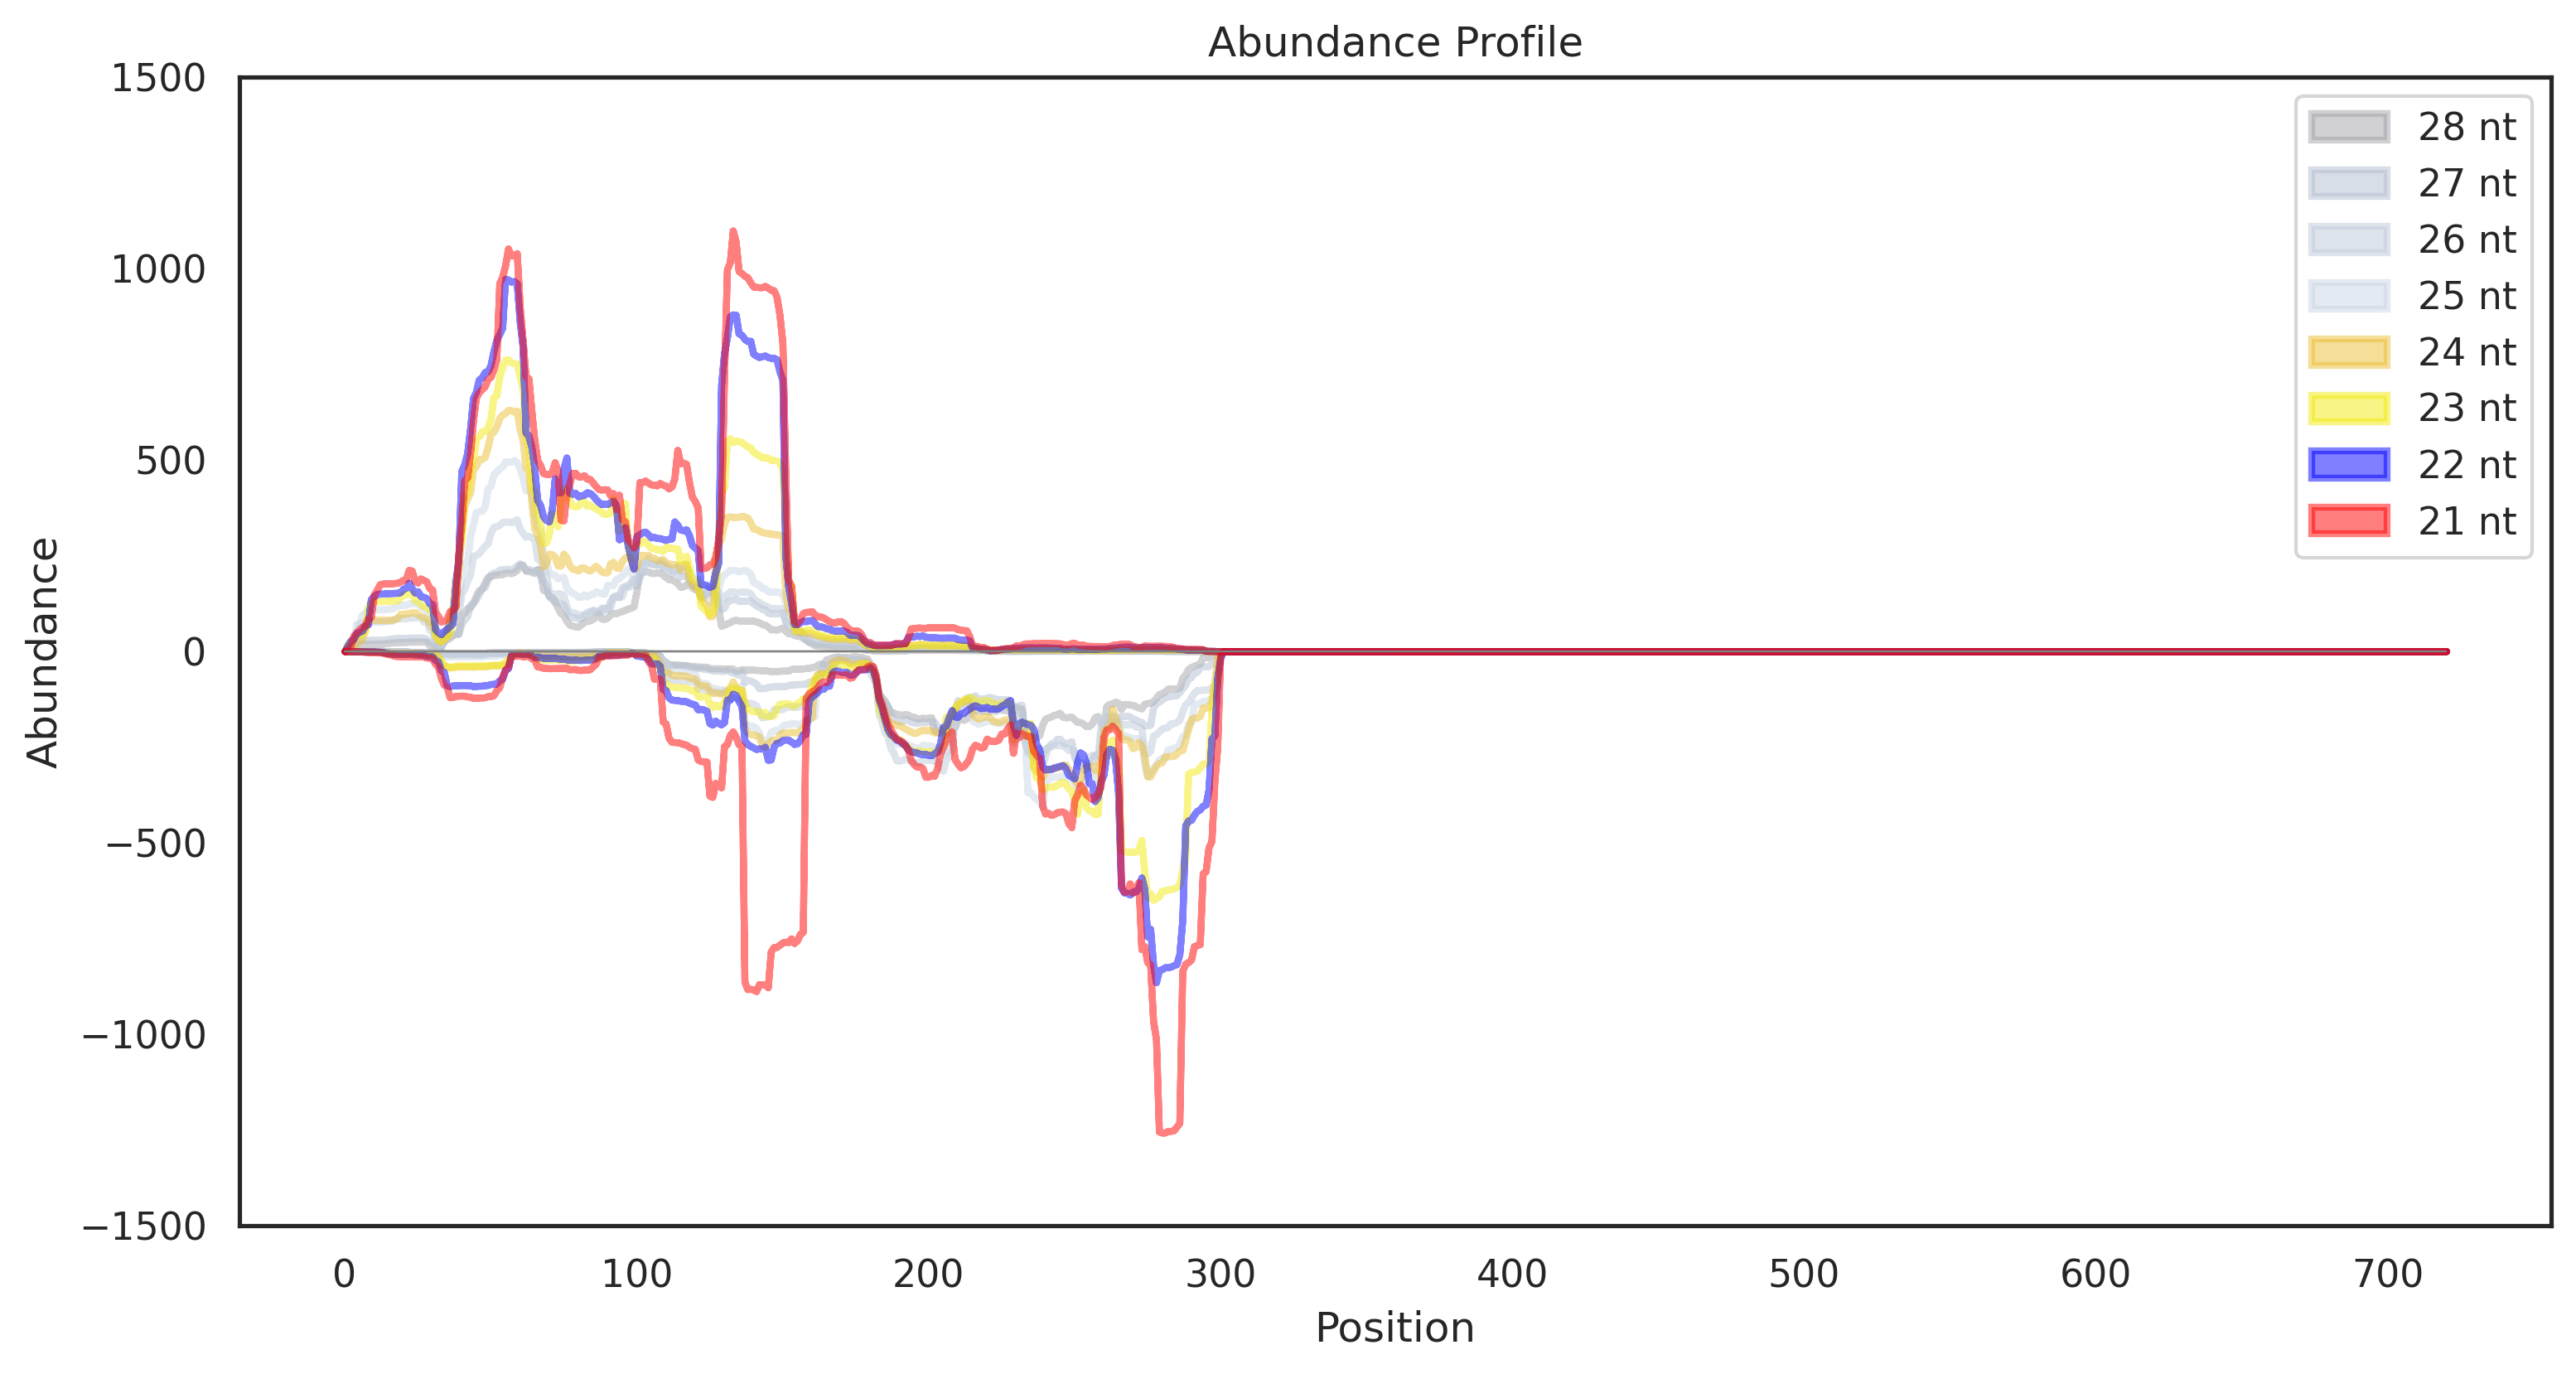

In [17]:
align_plot("brosnan_et_al/figures/fig_S8D/dcl234_dsGFP_bot_gfp_input",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-1500,1500), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S8D/dcl234_dsGFP_bot_gfp_input.png")


# Fig 5I

## dcl234 dsGFP bot GFP trapr

In [18]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_1.fq.gz,brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_2.fq.gz,brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_5I/dcl234_dsGFP_bot_gfp_trapr \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_2.fq.gz - 7,872,410 reads processed
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_1.fq.gz - 7,685,022 reads processed
brosnan_et_al/reads/234_dsGFP_bot_GFP_input_trapr/234_dsGFP_bot_GFP_trapr_3.fq.gz - 11,644,159 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 3.890146994s


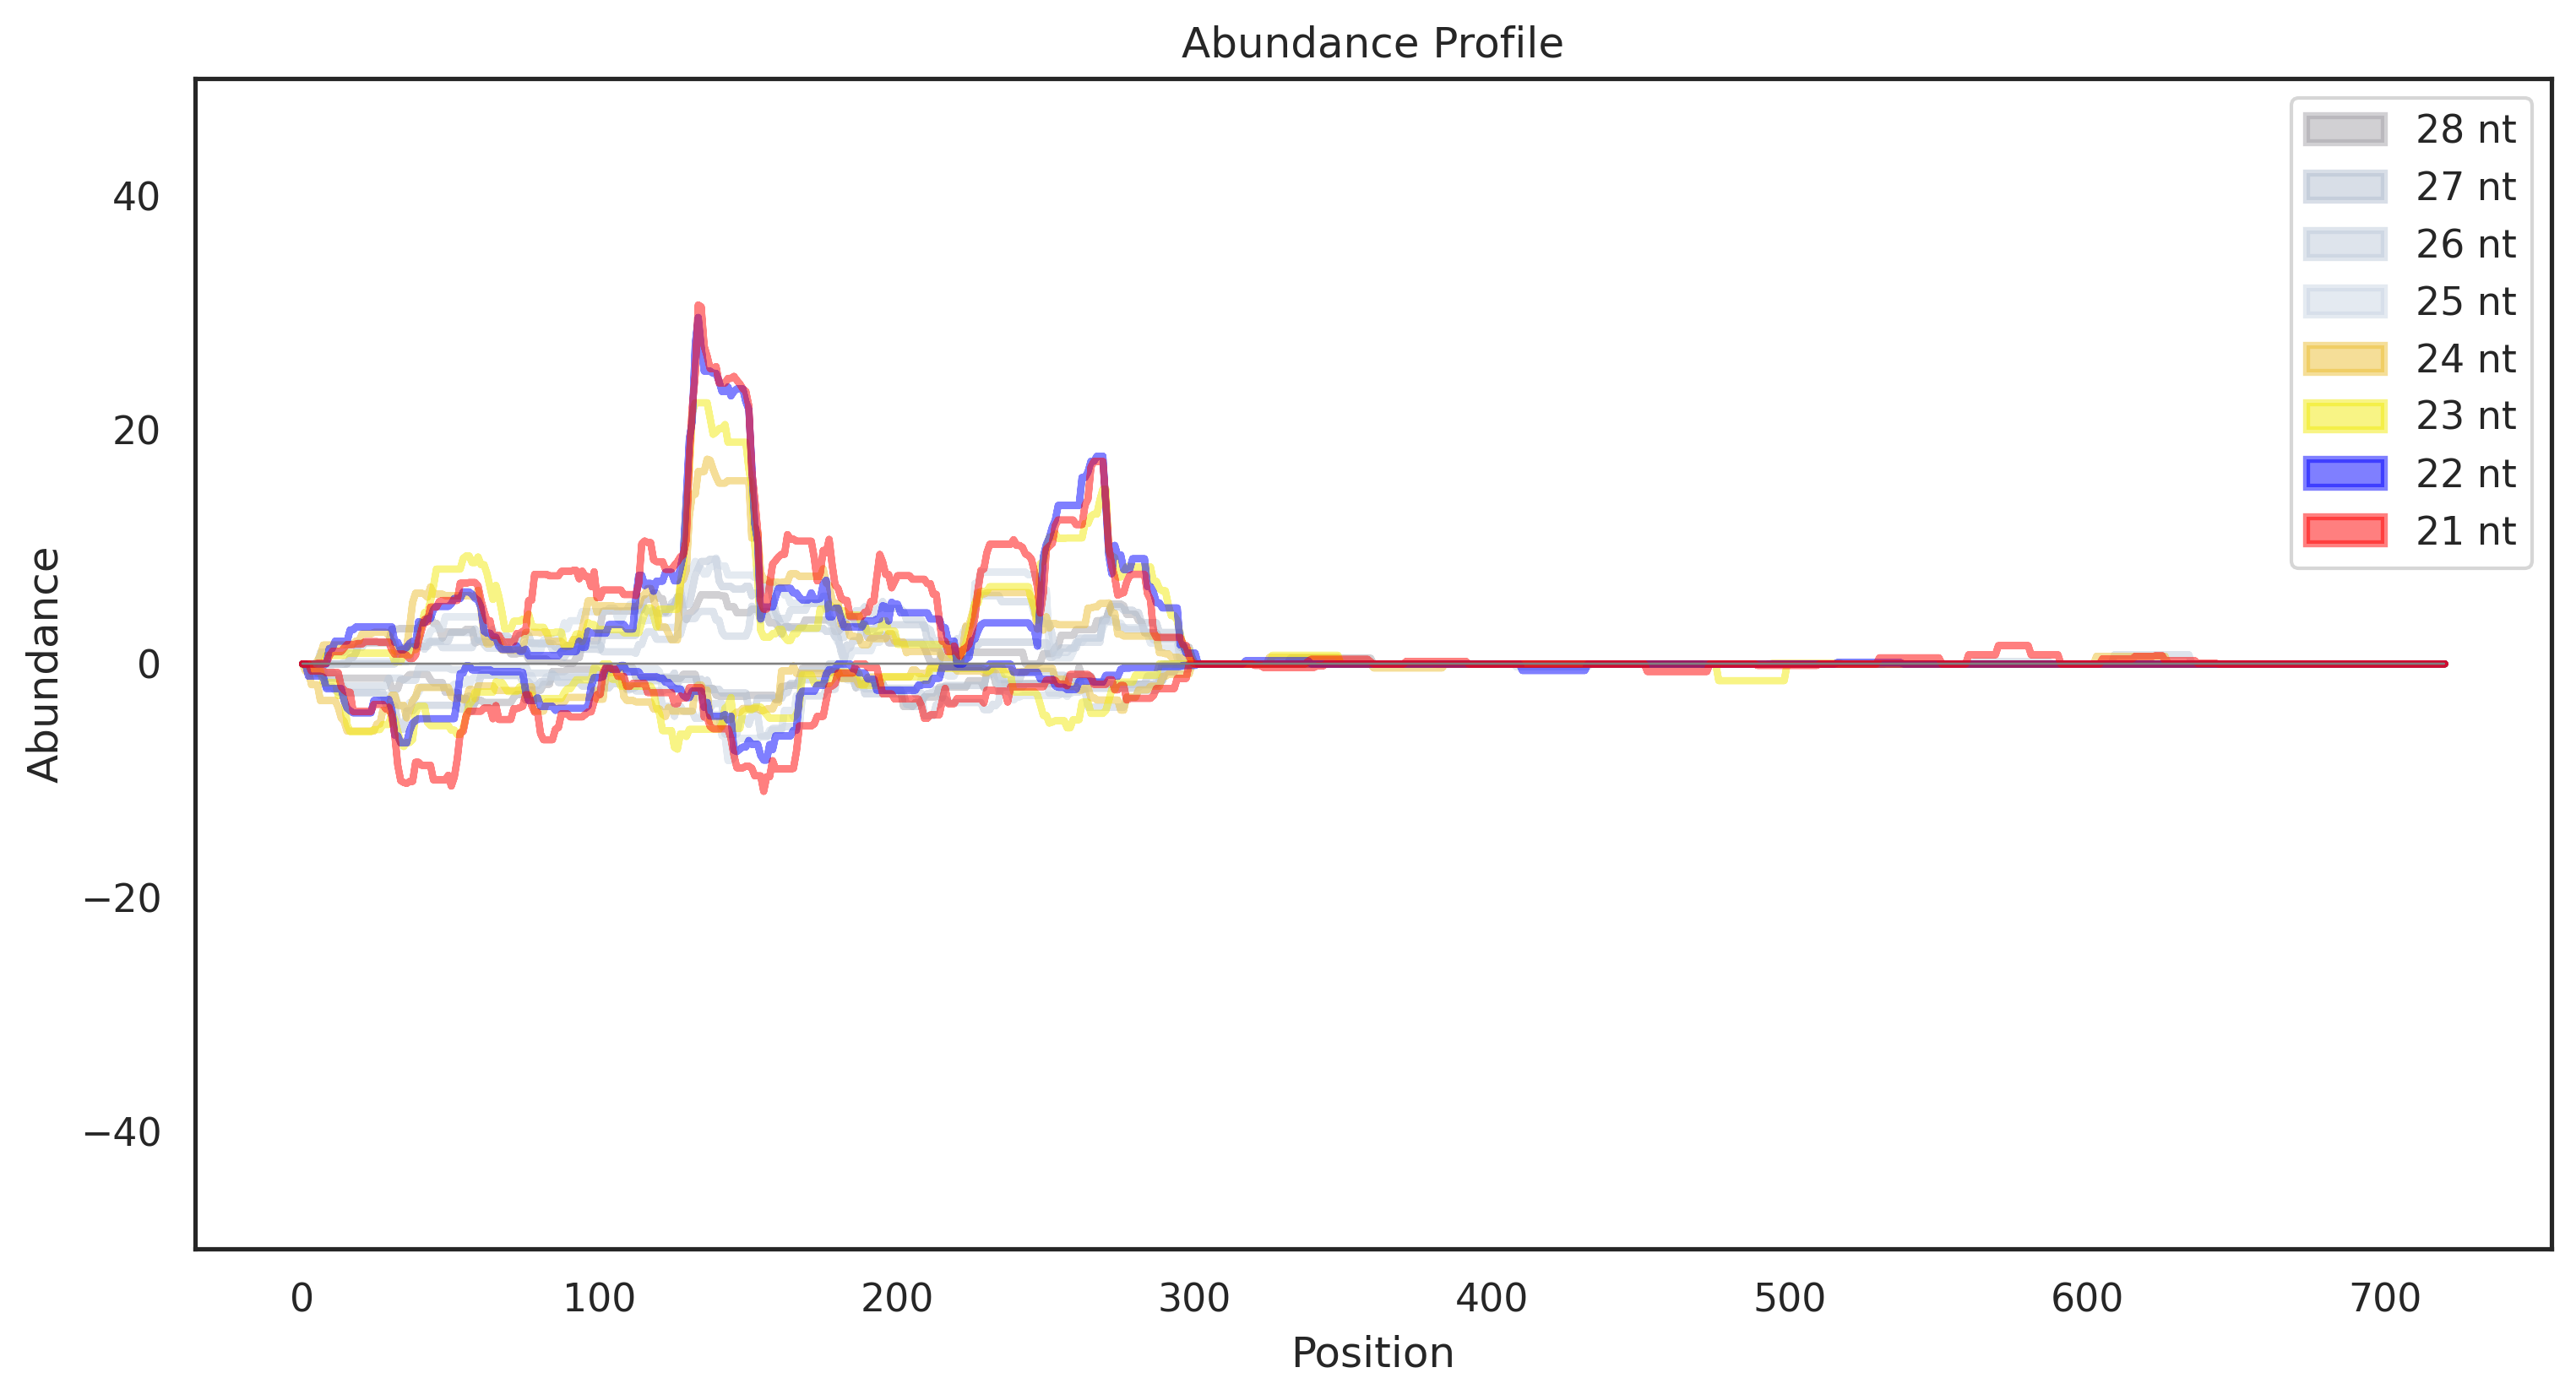

In [19]:
align_plot("brosnan_et_al/figures/fig_5I/dcl234_dsGFP_bot_gfp_trapr",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-50,50), se=True, abund=False, save_file="brosnan_et_al/figures/fig_5I/dcl234_dsGFP_bot_gfp_trapr.png")

##  GFP dsRNA

# Fig 5E

brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_1.fq.gz 2545835
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_2.fq.gz 3525906
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_3.fq.gz 4374161
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_1.fq.gz 12096505
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_2.fq.gz 11027684
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_3.fq.gz 8680590


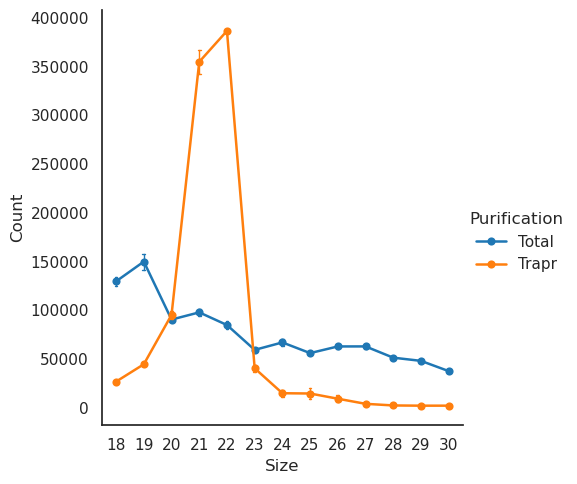

In [57]:
count_siRNAs(["brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_1.fq.gz",
              "brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_2.fq.gz",
              "brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_3.fq.gz"],
             ["brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_1.fq.gz",
              "brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_2.fq.gz",
              "brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_3.fq.gz"],
            "brosnan_et_al/figures/fig_5E/invitro_GFP_dsRNA_input_trapr.png")

# Fig 5F

### invitro_botrytis_GFP_dsRNA_input

In [58]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa\
    -1 brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_1.fq.gz,brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_2.fq.gz,brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_5F/invitro_botrytis_GFP_dsRNA_input \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_1.fq.gz - 2,545,835 reads processed
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_2.fq.gz - 3,525,906 reads processed
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_input_3.fq.gz - 4,374,161 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 1.6890736s


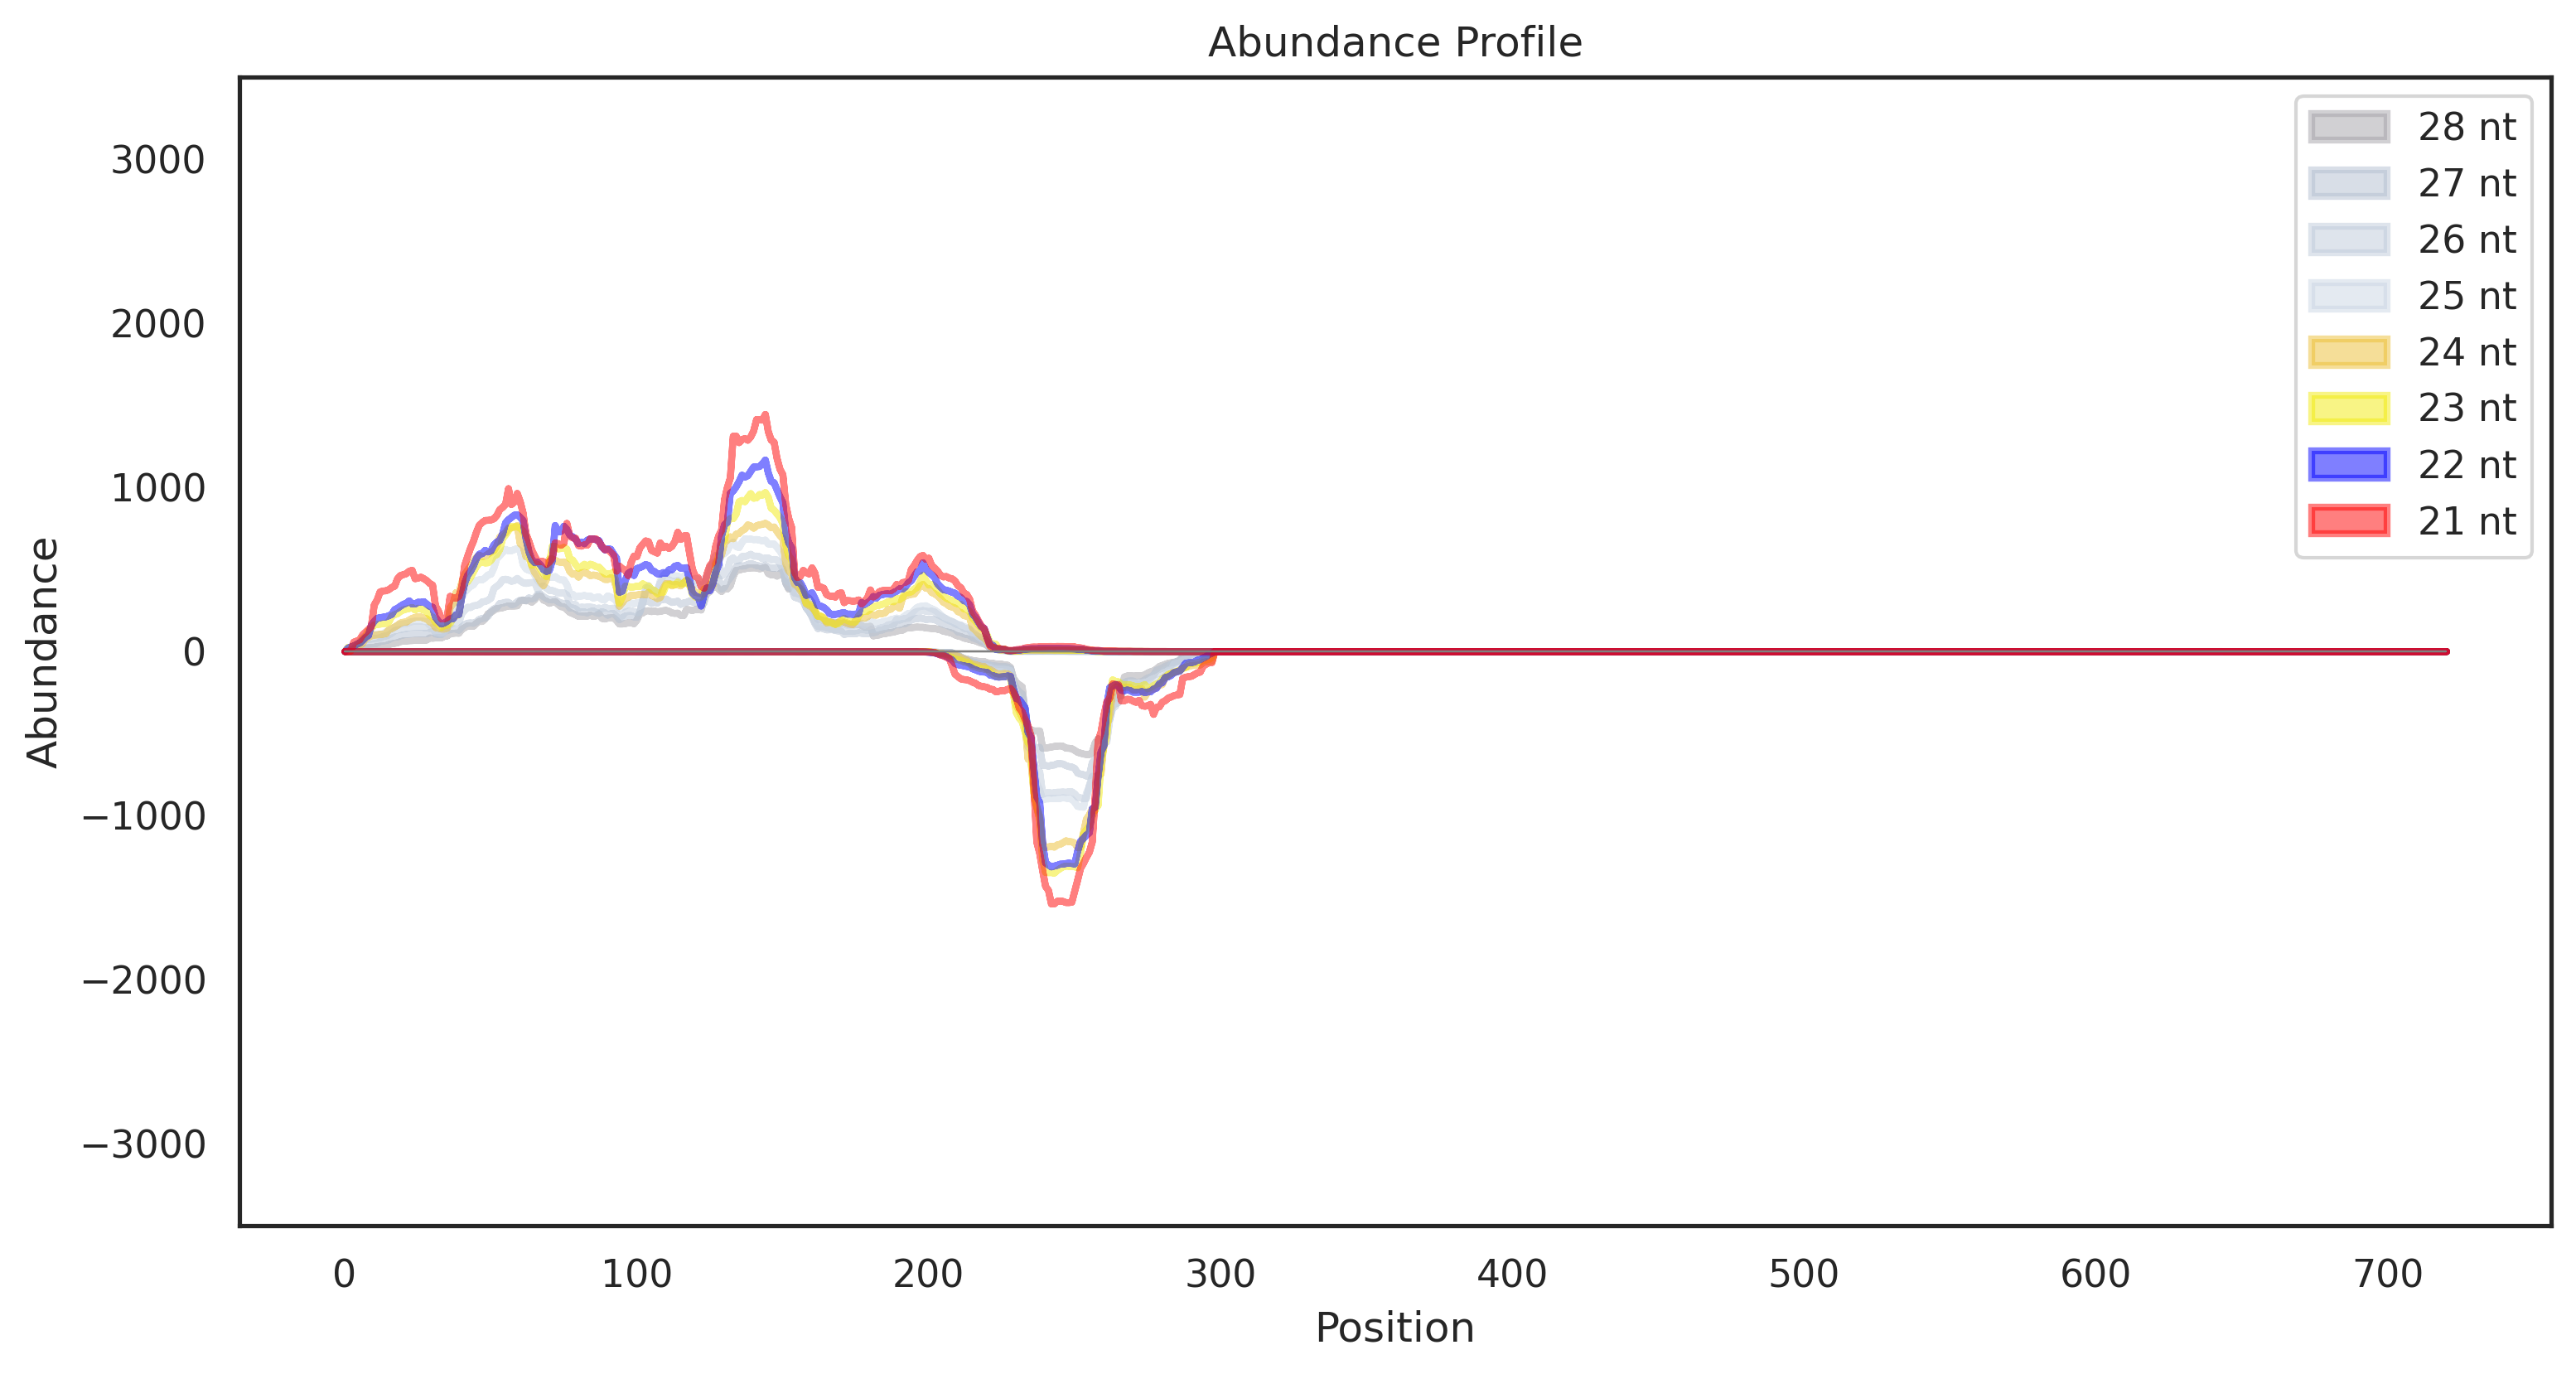

In [59]:
align_plot("brosnan_et_al/figures/fig_5F/invitro_botrytis_GFP_dsRNA_input",
             [28,27,26,25,24,23,22,21], 
             "eGFP",ylim_set=(-3500,3500), abund=False, save_file = "brosnan_et_al/figures/fig_5F/invitro_botrytis_GFP_dsRNA_input.png")

# Fig 5G

### invitro_botrytis_GFP_dsRNA_trapr

In [60]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_1.fq.gz,brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_2.fq.gz,brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_5G/invitro_botrytis_GFP_dsRNA_trapr \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_3.fq.gz - 8,680,590 reads processed
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_2.fq.gz - 11,027,684 reads processed
brosnan_et_al/reads/invitro_dsGFP_bot_GFP_input_trapr/invitro_dsGFP_bot_GFP_trapr_1.fq.gz - 12,096,505 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 5.448458752s


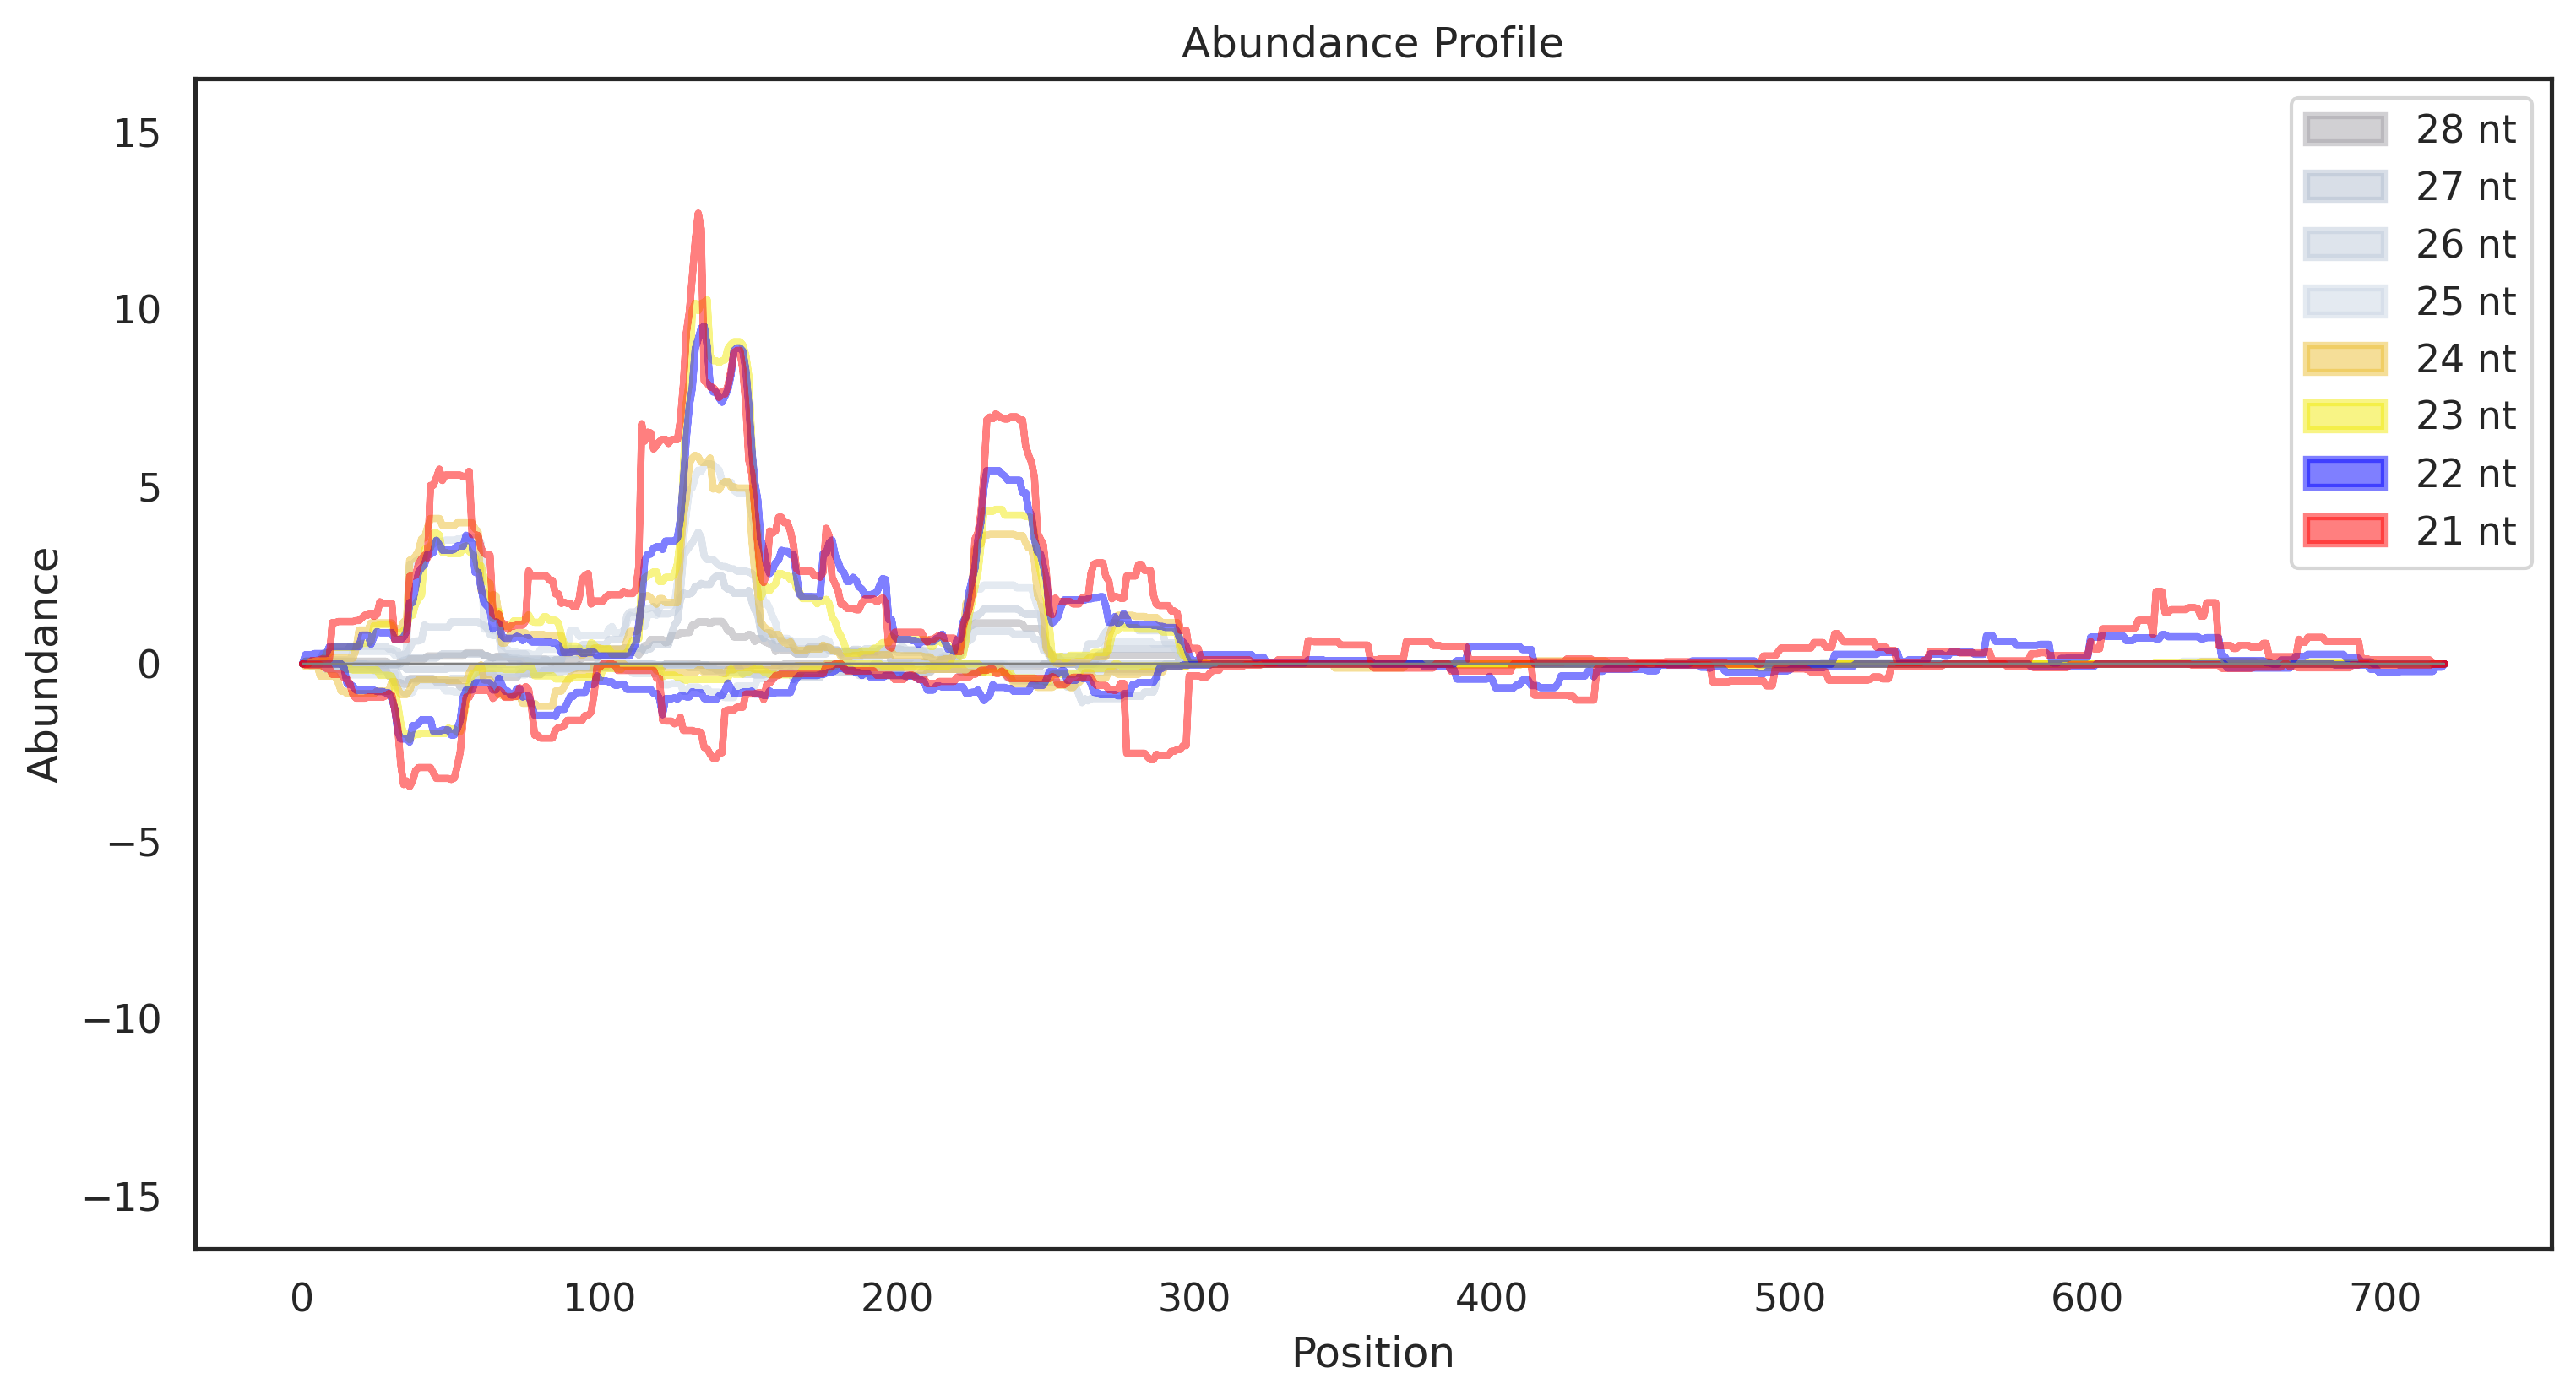

In [61]:
align_plot("brosnan_et_al/figures/fig_5G/invitro_botrytis_GFP_dsRNA_trapr",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-16.5,16.5), se=True, abund=False, save_file="brosnan_et_al/figures/fig_5G/invitro_botrytis_GFP_dsRNA_trapr.png")

# Fig S7A

## No GFP dsRNA

brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_1.fq.gz 7972727
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_2.fq.gz 6256414
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_3.fq.gz 11046812
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_1.fq.gz 4920685
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_2.fq.gz 4526930
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_3.fq.gz 12212668


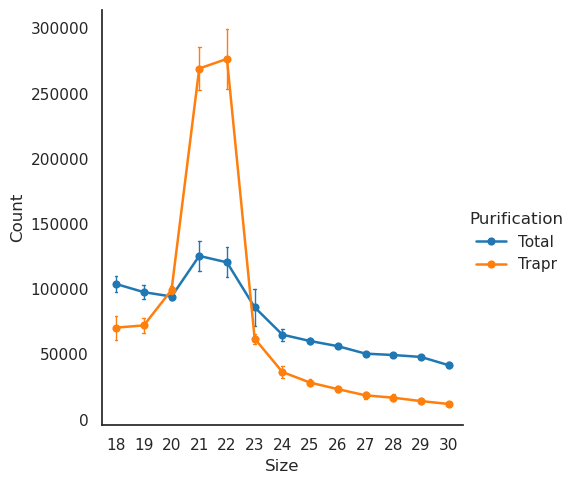

In [40]:
count_siRNAs(["brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_1.fq.gz",
              "brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_2.fq.gz", 
              "brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_3.fq.gz"],
             ["brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_1.fq.gz",
              "brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_2.fq.gz", 
              "brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_3.fq.gz"],
            "brosnan_et_al/figures/fig_S7A/invitro_input_trapr.png")

# Fig S7B

### invitro_botrytis_no_dsRNA_input

In [41]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_1.fq.gz,brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_2.fq.gz,brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_3.fq.gz \
    -l 20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S7B/invitro_botrytis_no_dsRNA_input \
    -t fq 


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_2.fq.gz - 6,256,414 reads processed
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_1.fq.gz - 7,972,727 reads processed
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_input_3.fq.gz - 11,800,211 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 9.522769434s


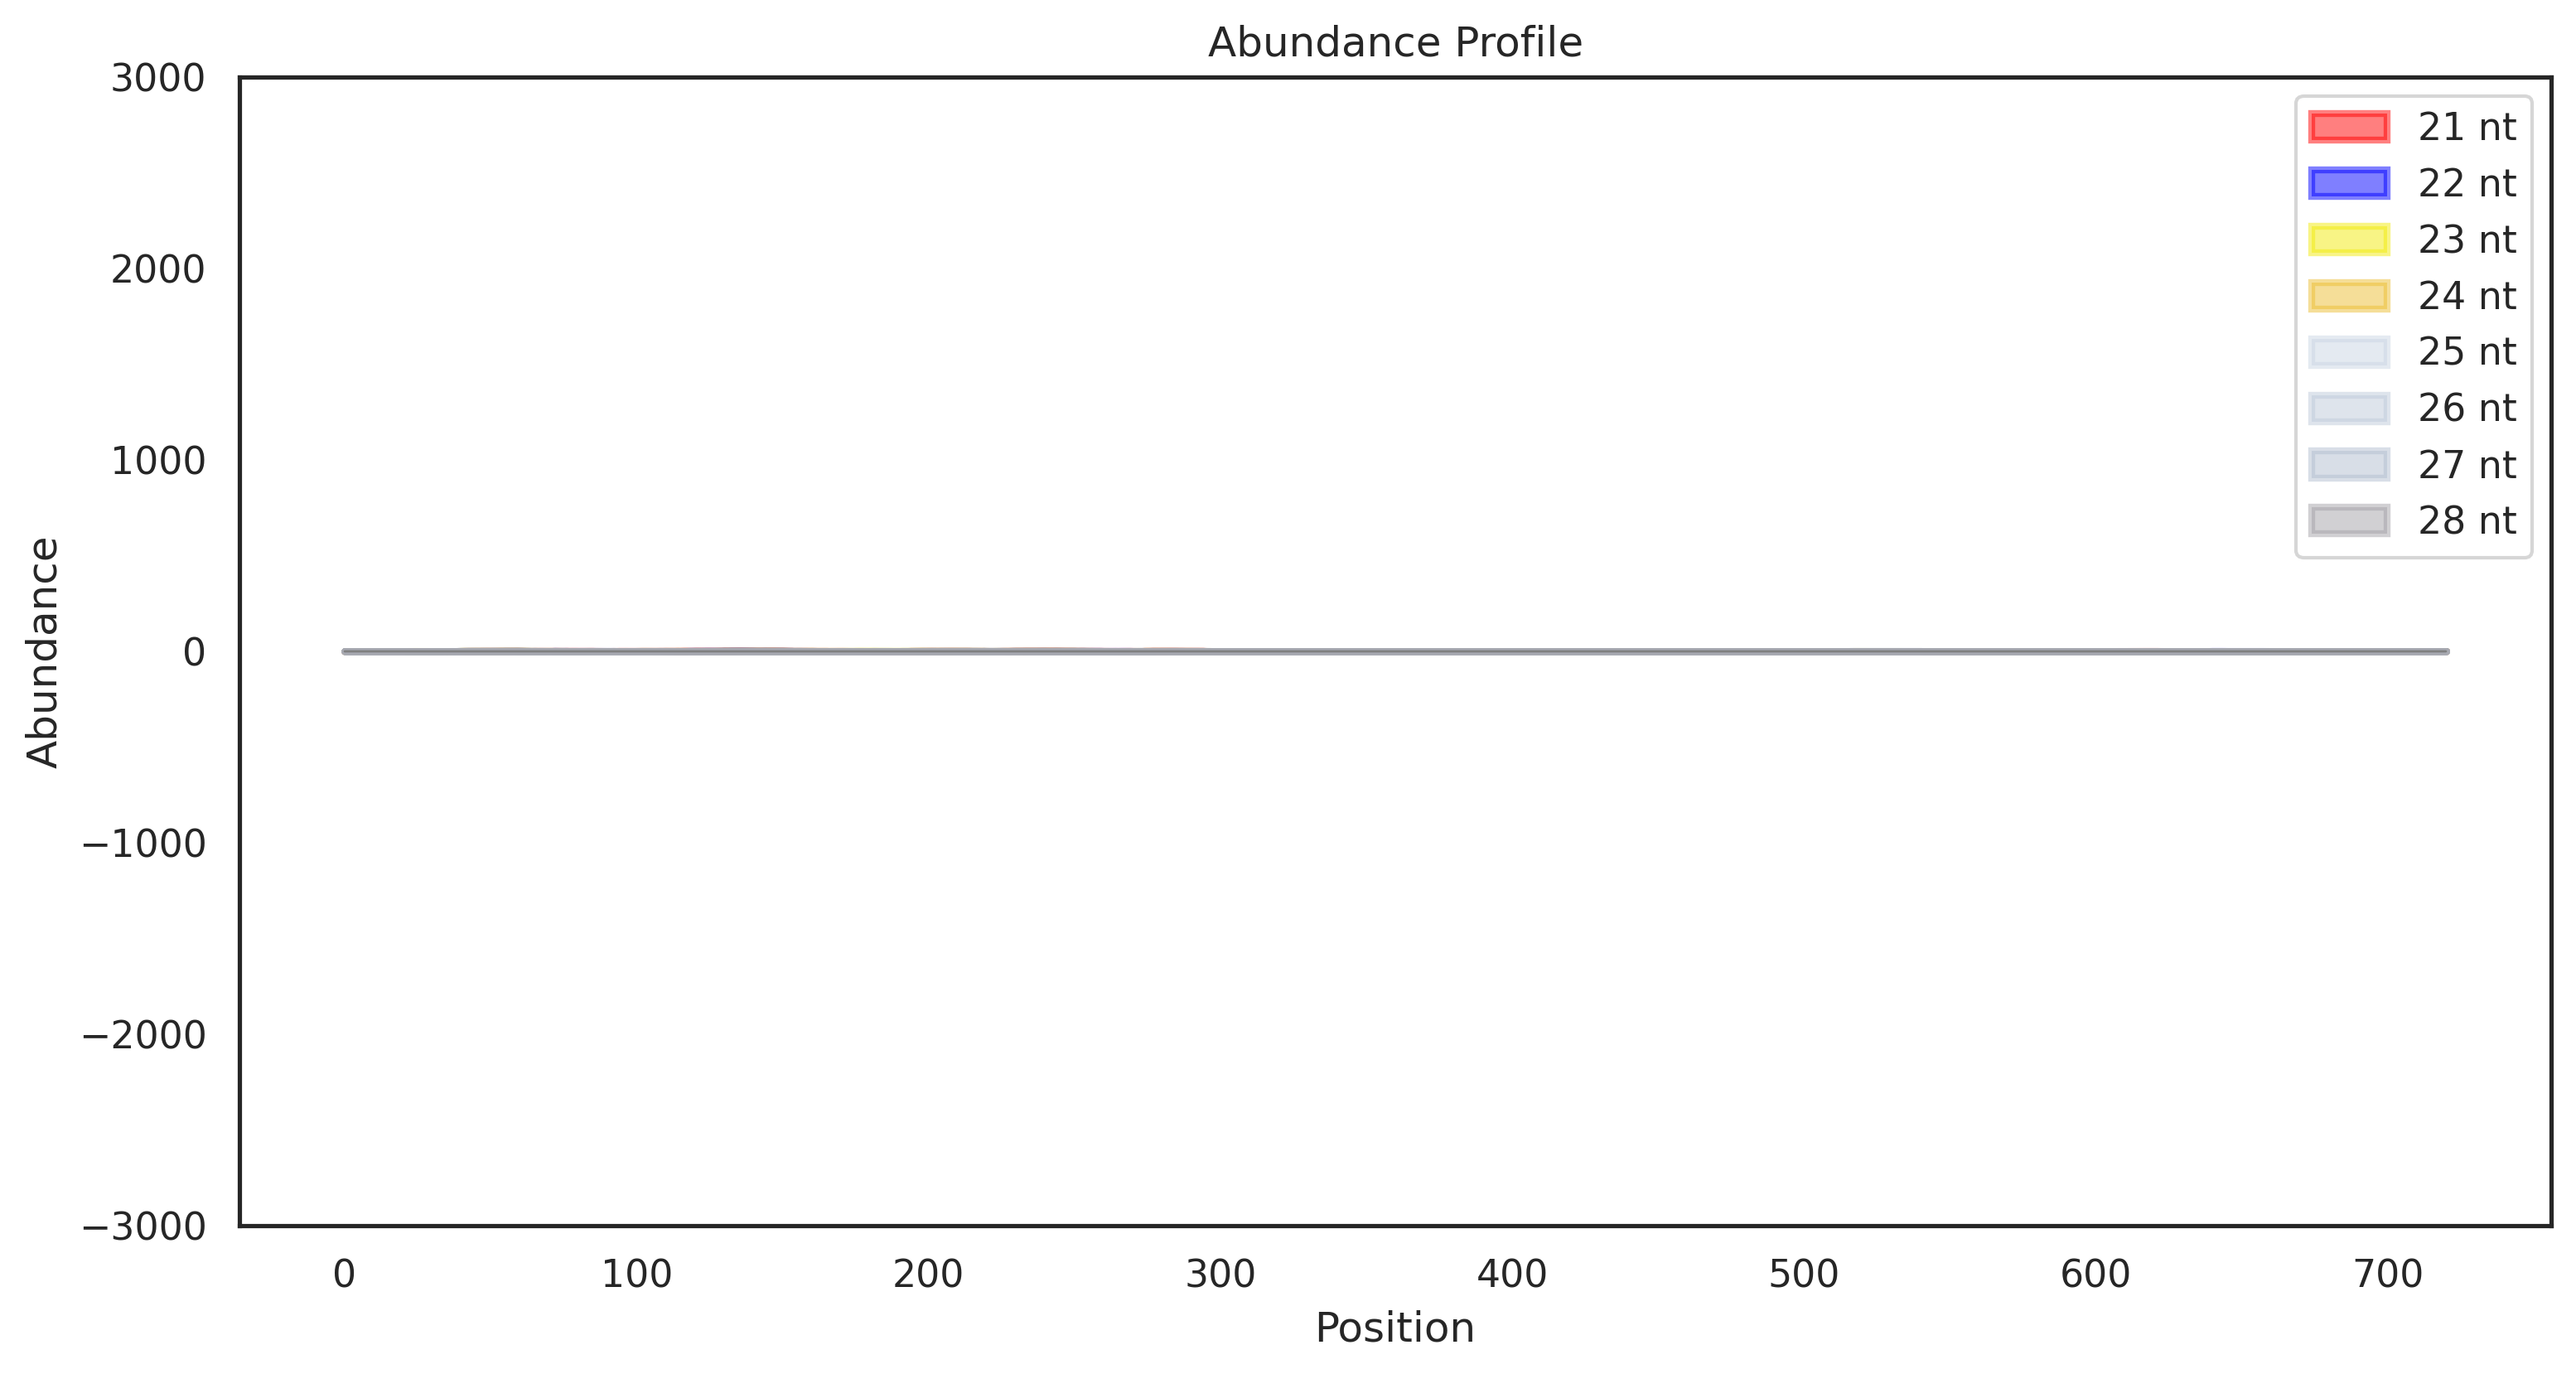

In [42]:
align_plot("brosnan_et_al/figures/fig_S7B/invitro_botrytis_no_dsRNA_input",
             [21,22,23,24,25,26,27,28], 
             "eGFP", ylim_set=(-3000,3000), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S7B/invitro_botrytis_no_dsRNA_input.png")


# Fig S7C

### invitro_botrytis_no_dsRNA_trapr

In [43]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_1.fq.gz,brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_2.fq.gz,brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S7C/invitro_botrytis_no_dsRNA_trapr \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_2.fq.gz - 4,526,930 reads processed
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_1.fq.gz - 4,920,685 reads processed
brosnan_et_al/reads/invitro_neg_GFP_bot_input_trapr/invitro_neg_GFP_bot_trapr_3.fq.gz - 12,443,788 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 6.243888315s


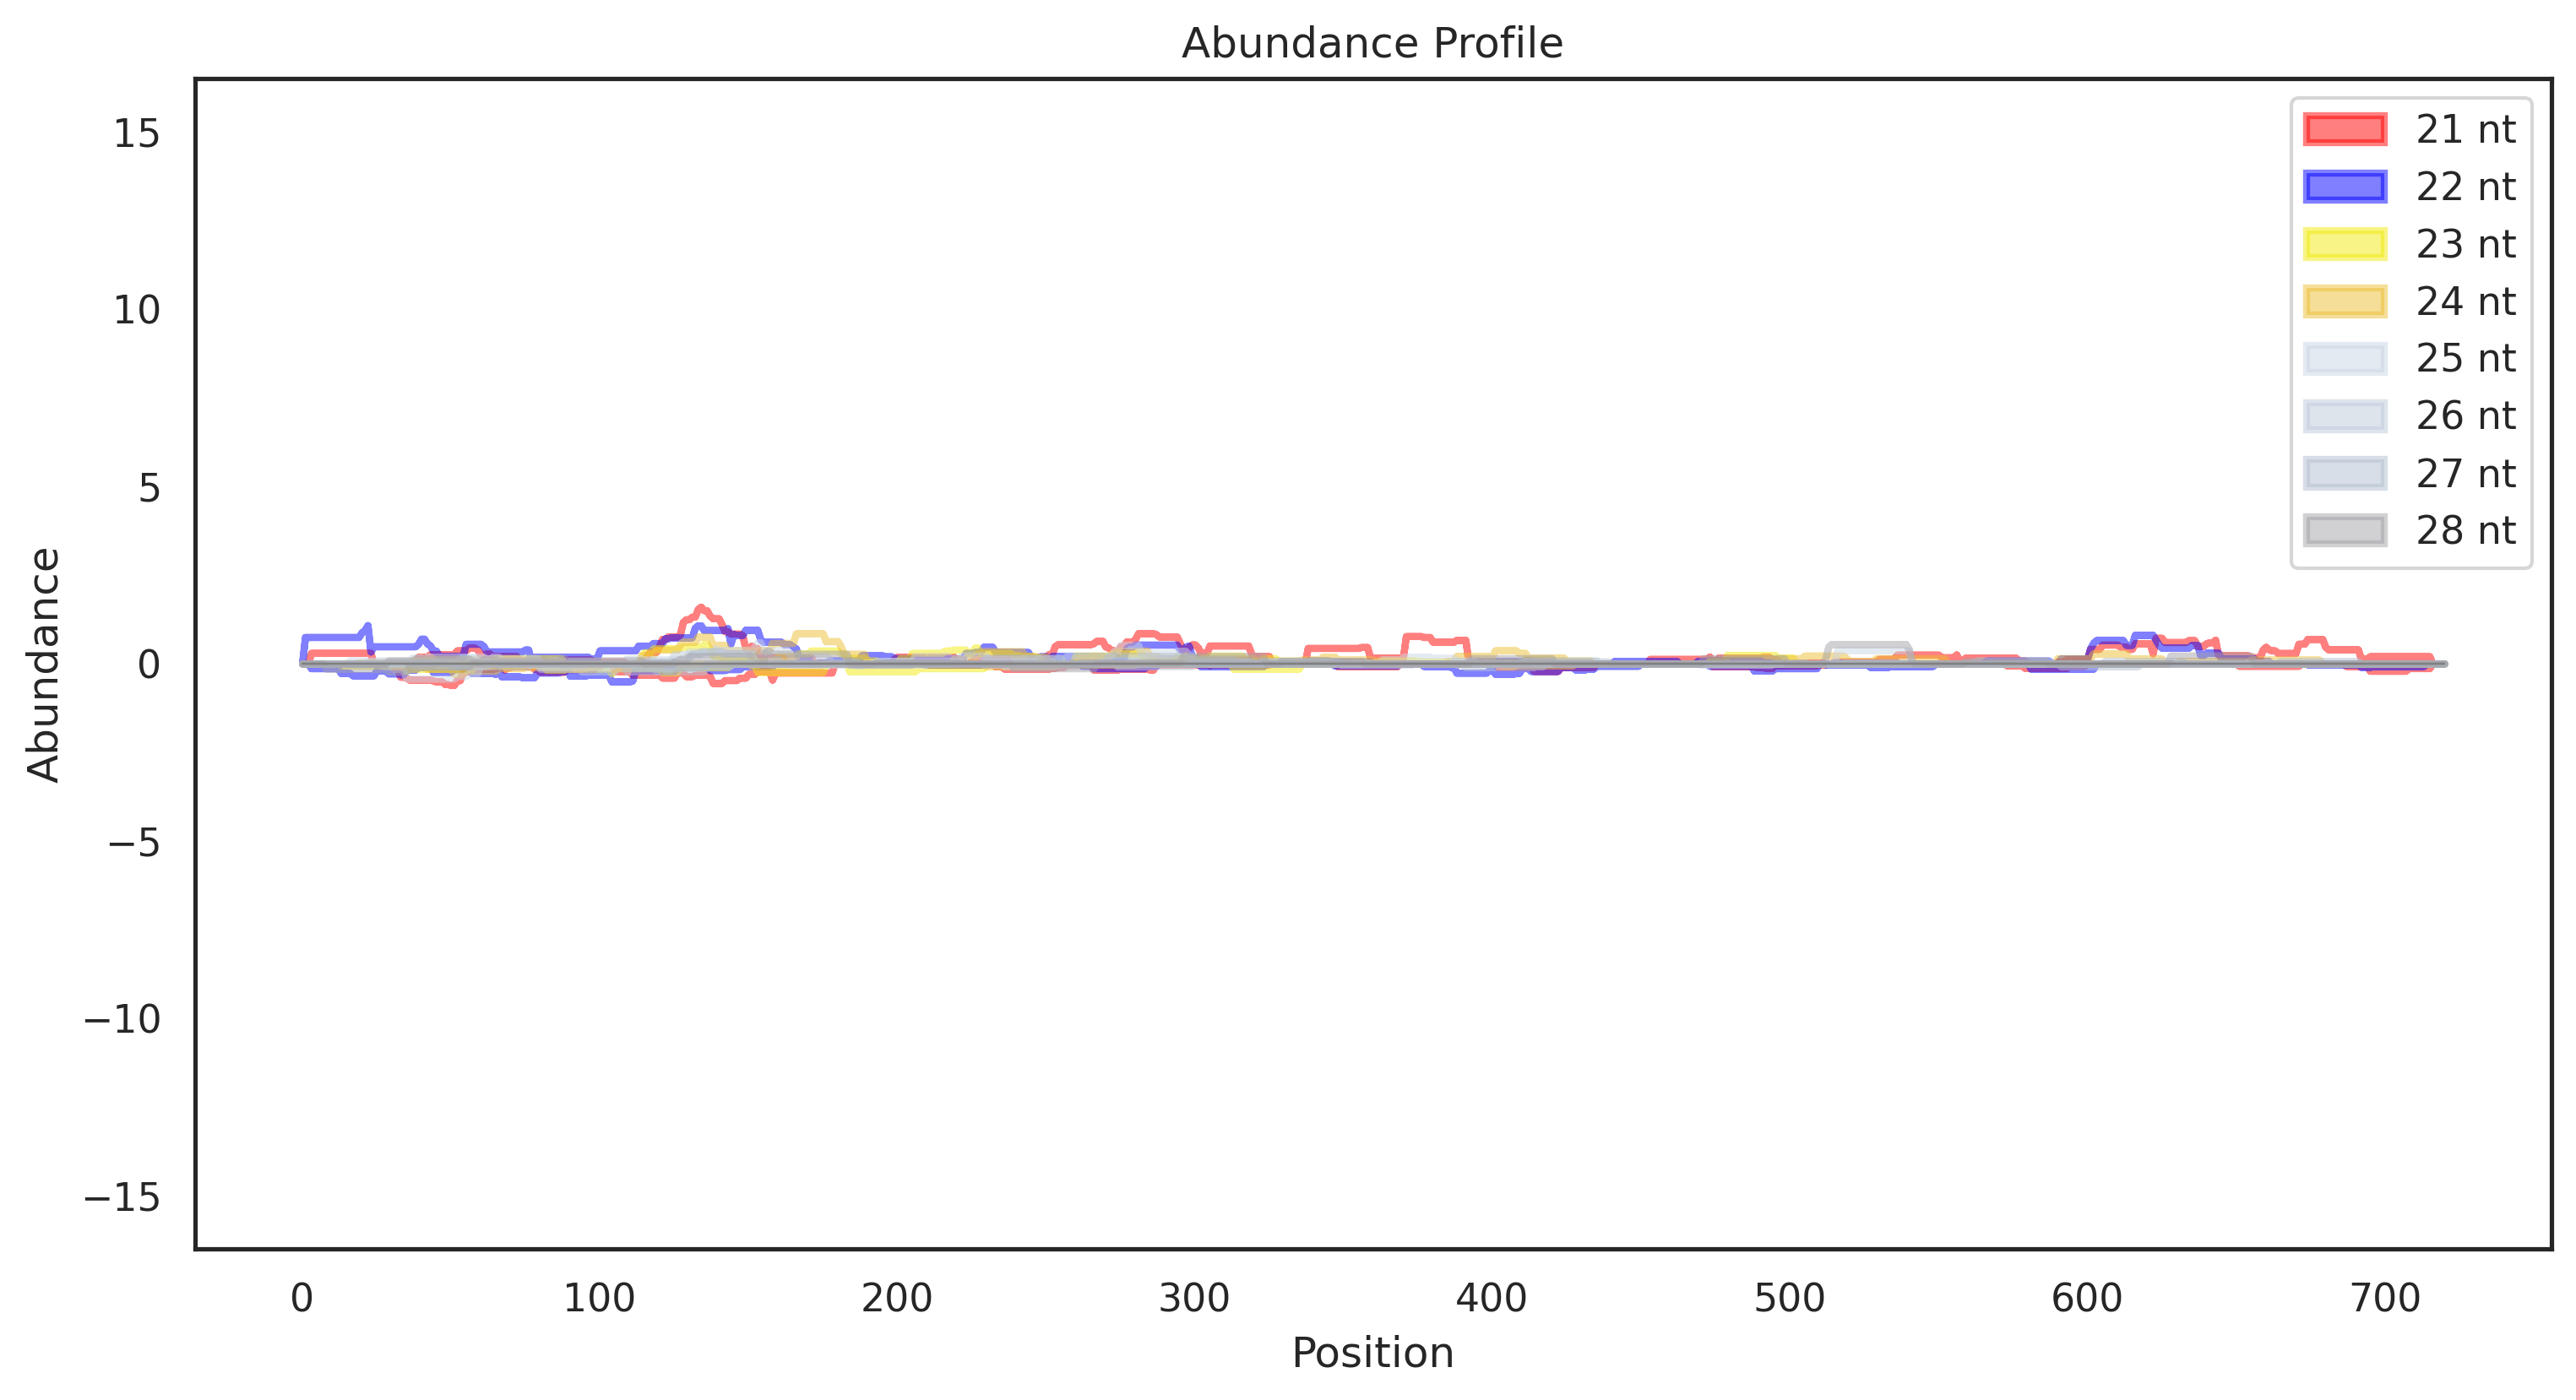

In [44]:
align_plot("brosnan_et_al/figures/fig_S7C/invitro_botrytis_no_dsRNA_trapr",
             [21,22,23,24,25,26,27,28], 
             "eGFP", ylim_set=(-16.5,16.5), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S7C/invitro_botrytis_no_dsRNA_trapr.png")


# Fig S9B

### 234

In [45]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_1.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_2.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S9B/234_vert_eGFP \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_1.fq.gz - 1,886,747 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_2.fq.gz - 2,113,848 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_3.fq.gz - 3,292,668 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 2.112745333s


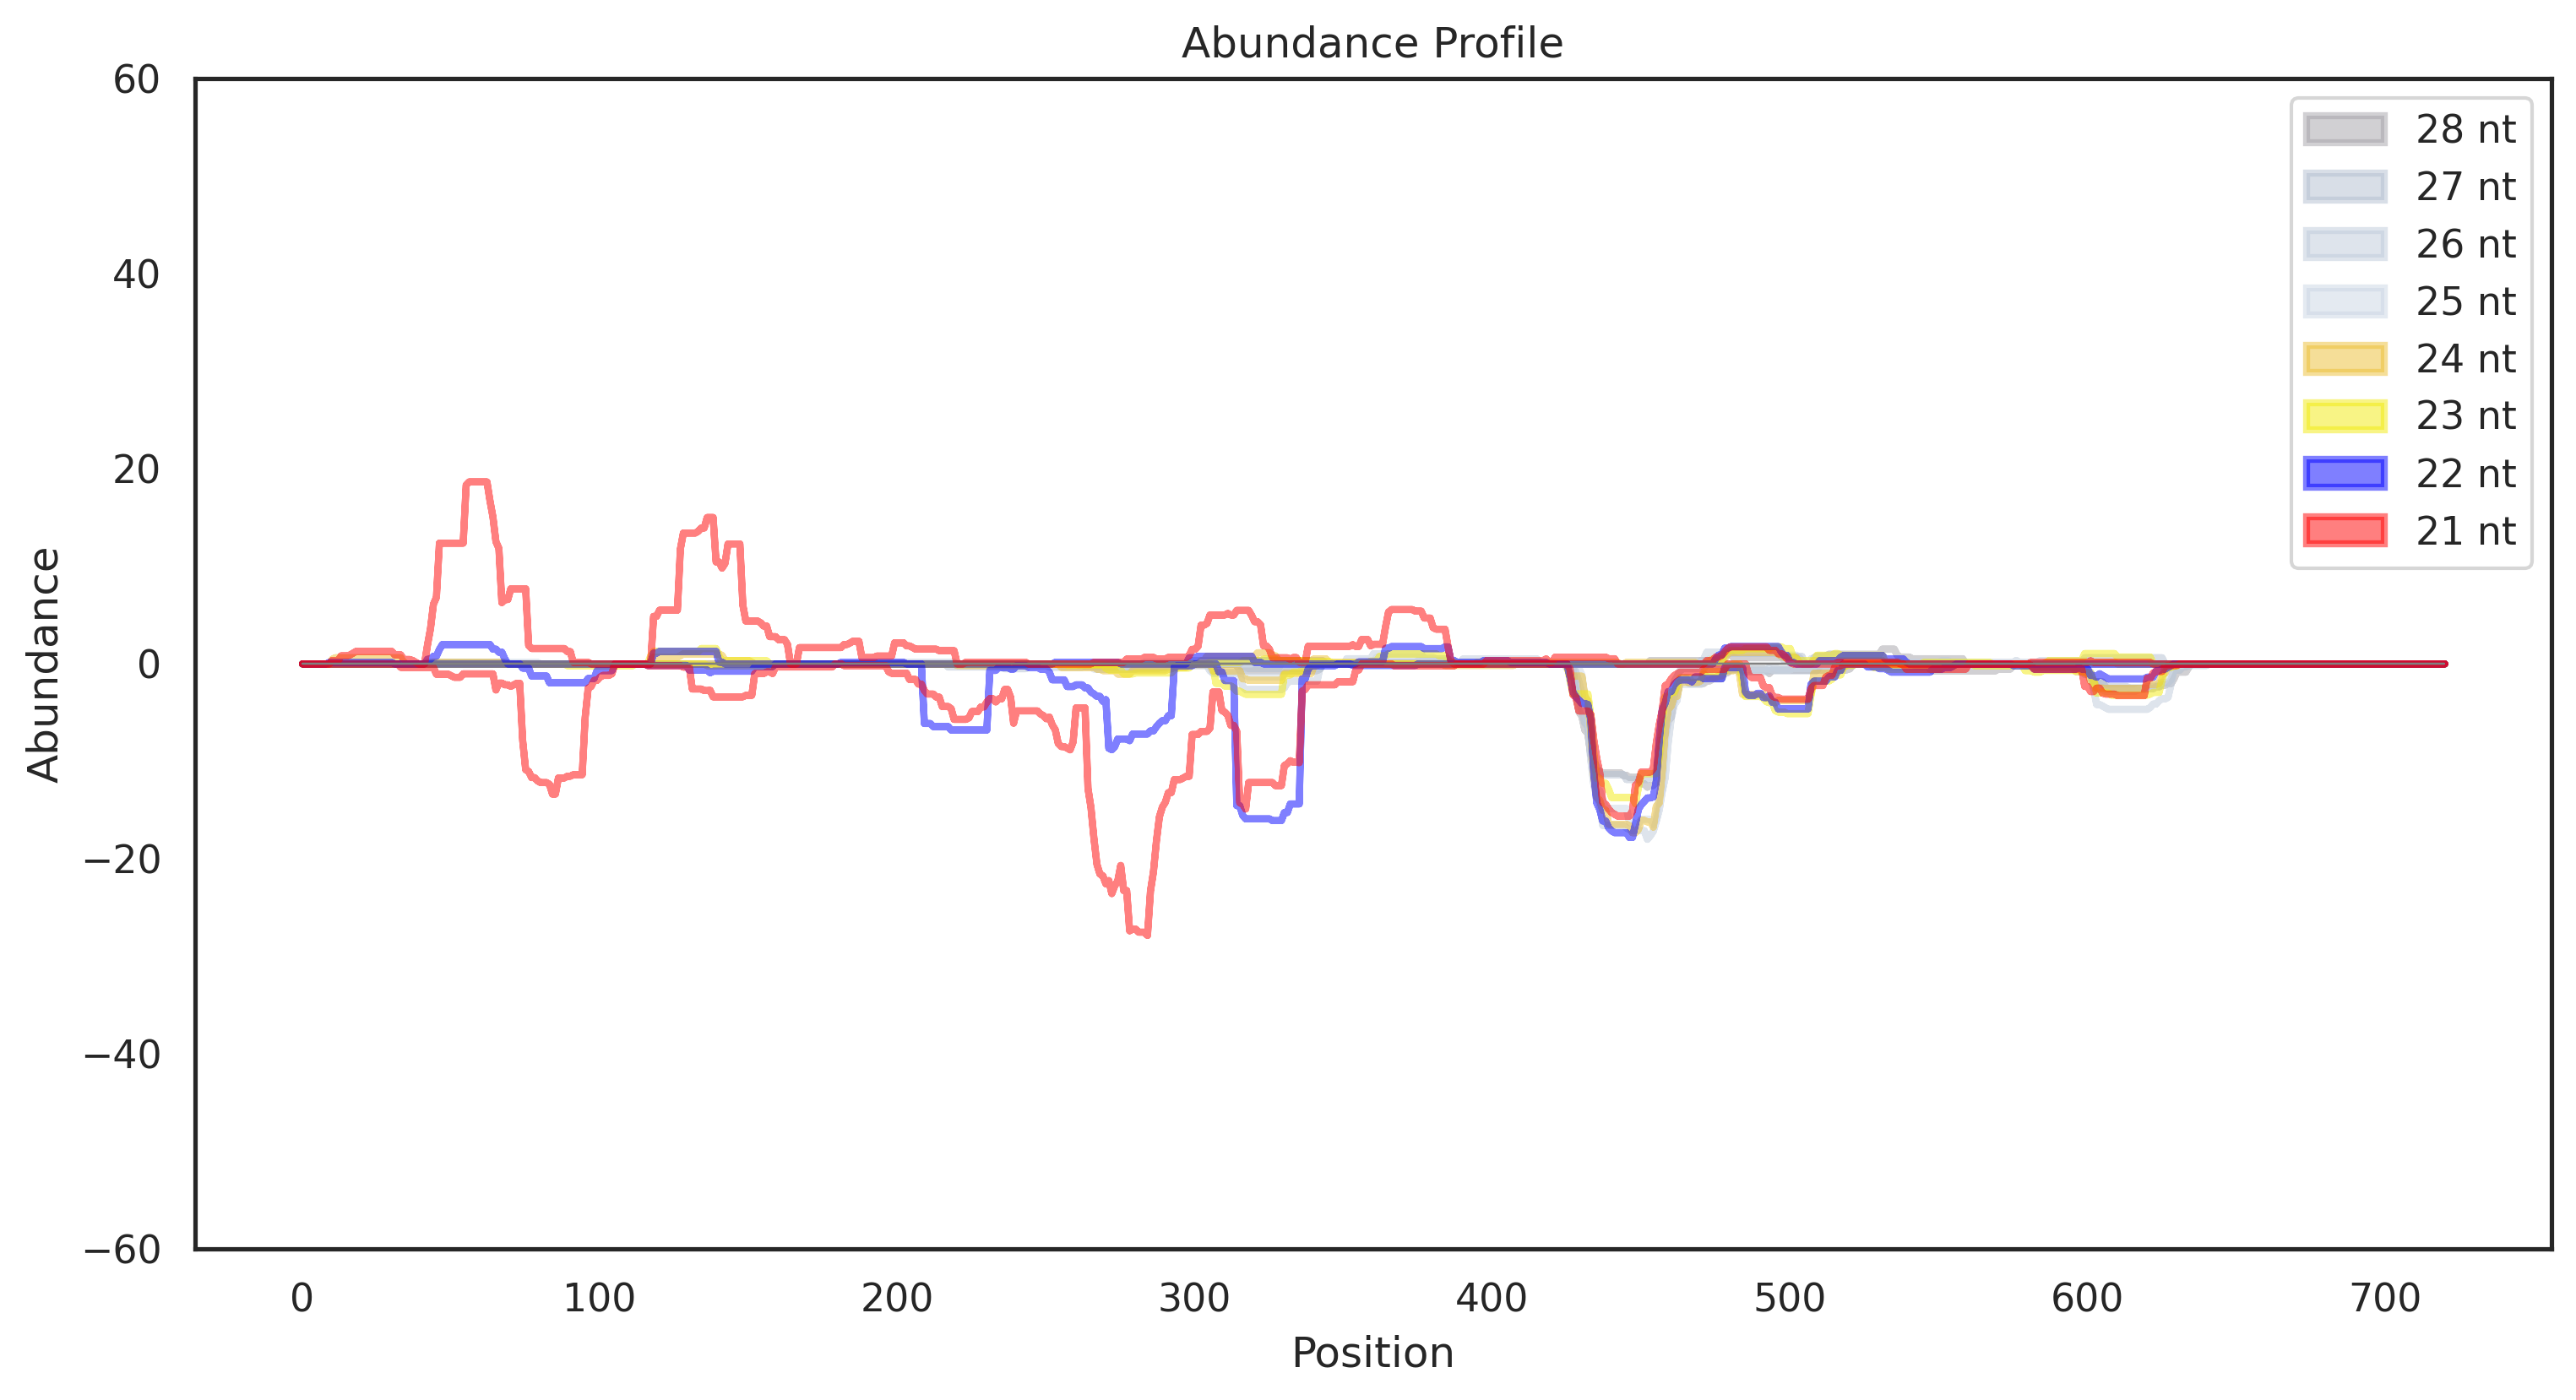

In [46]:
align_plot("brosnan_et_al/figures/fig_S9B/234_vert_eGFP",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-60,60), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S9B/234_vert_eGFP.png")


# Fig 6C

## Aligned to eGFP_GUS

In [47]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP_GUS.fa \
    -1 brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_1.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_2.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_3.fq.gz \
    -l 20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_6C/234_vert_GFP_GUS \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_1.fq.gz - 1,886,747 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_2.fq.gz - 2,113,848 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/234_dsGFP-GUS_vert_GFP_input_3.fq.gz - 3,292,668 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 501 nt

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 2.153834641s


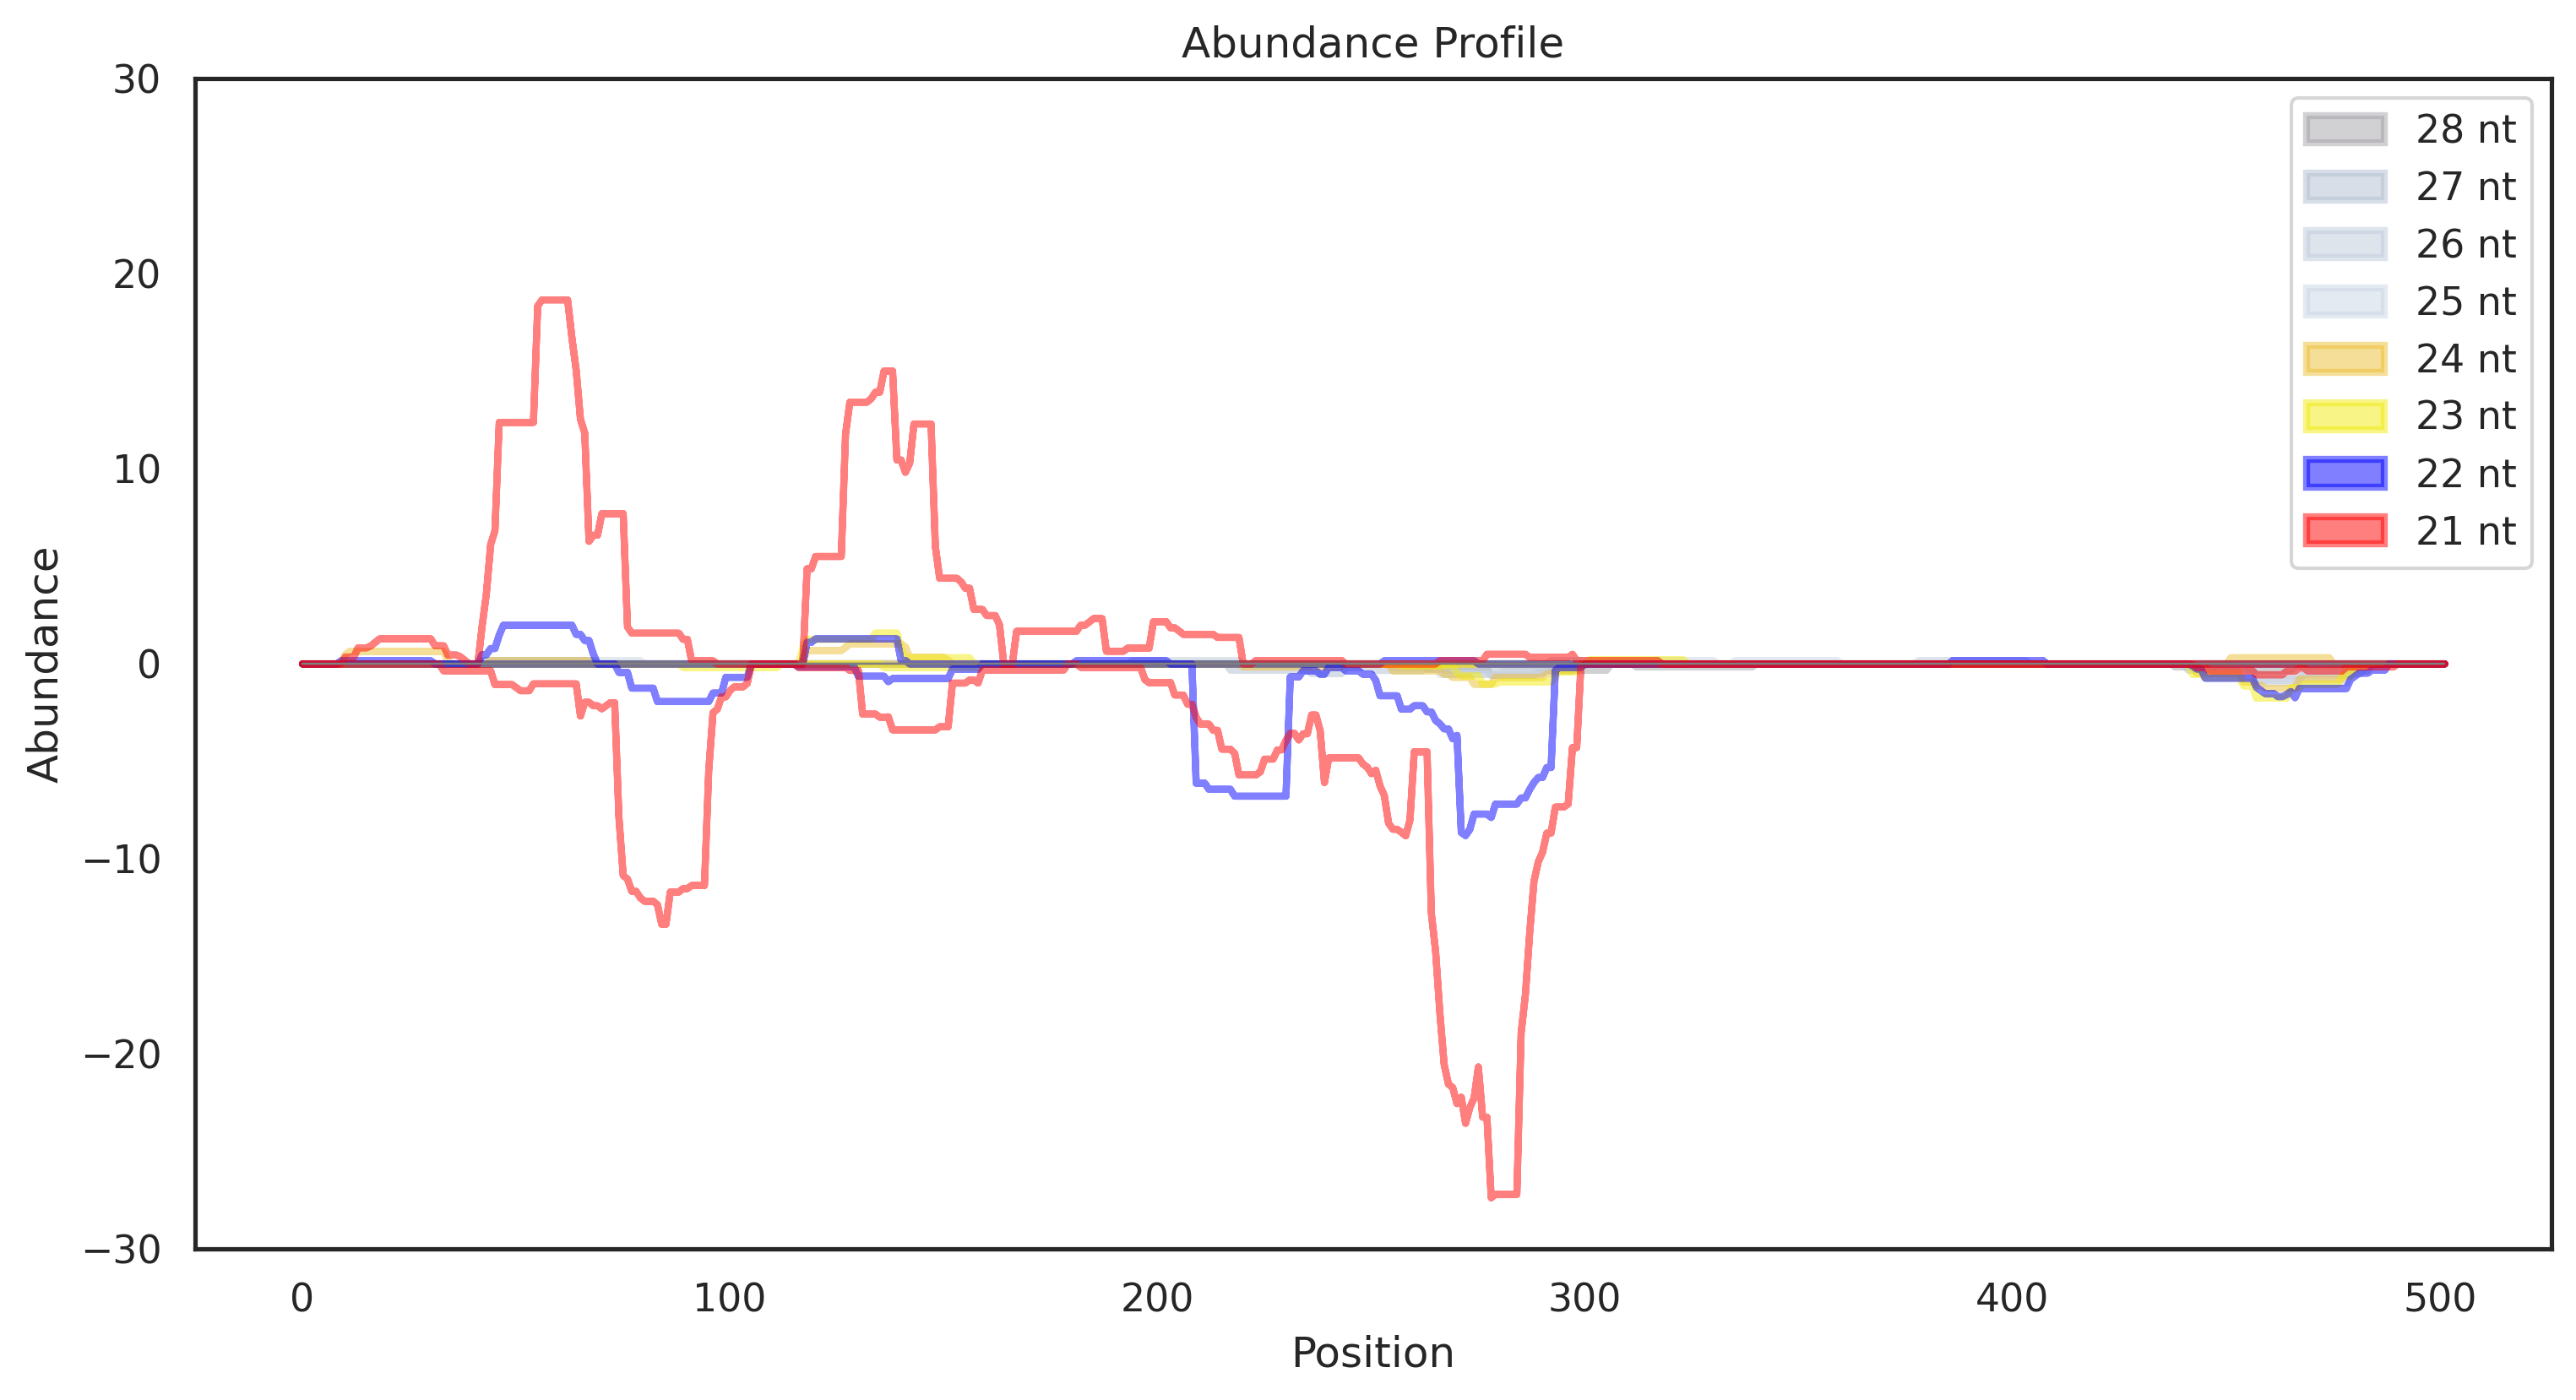

In [48]:
align_plot("brosnan_et_al/figures/fig_6C/234_vert_GFP_GUS",
             [28,27,26,25,24,23,22,21], 
             "eGFP_GUS",ylim_set=(-30,30), abund=False, save_file = "brosnan_et_al/figures/fig_6C/234_vert_GFP_GUS.png")

# Fig S9A

### Col

In [49]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP.fa \
    -1 brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_1.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_2.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_S9A/Col_vert_eGFP \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_3.fq.gz - 1,507,385 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_2.fq.gz - 1,687,265 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_1.fq.gz - 2,836,793 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 720 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 2.007097437s


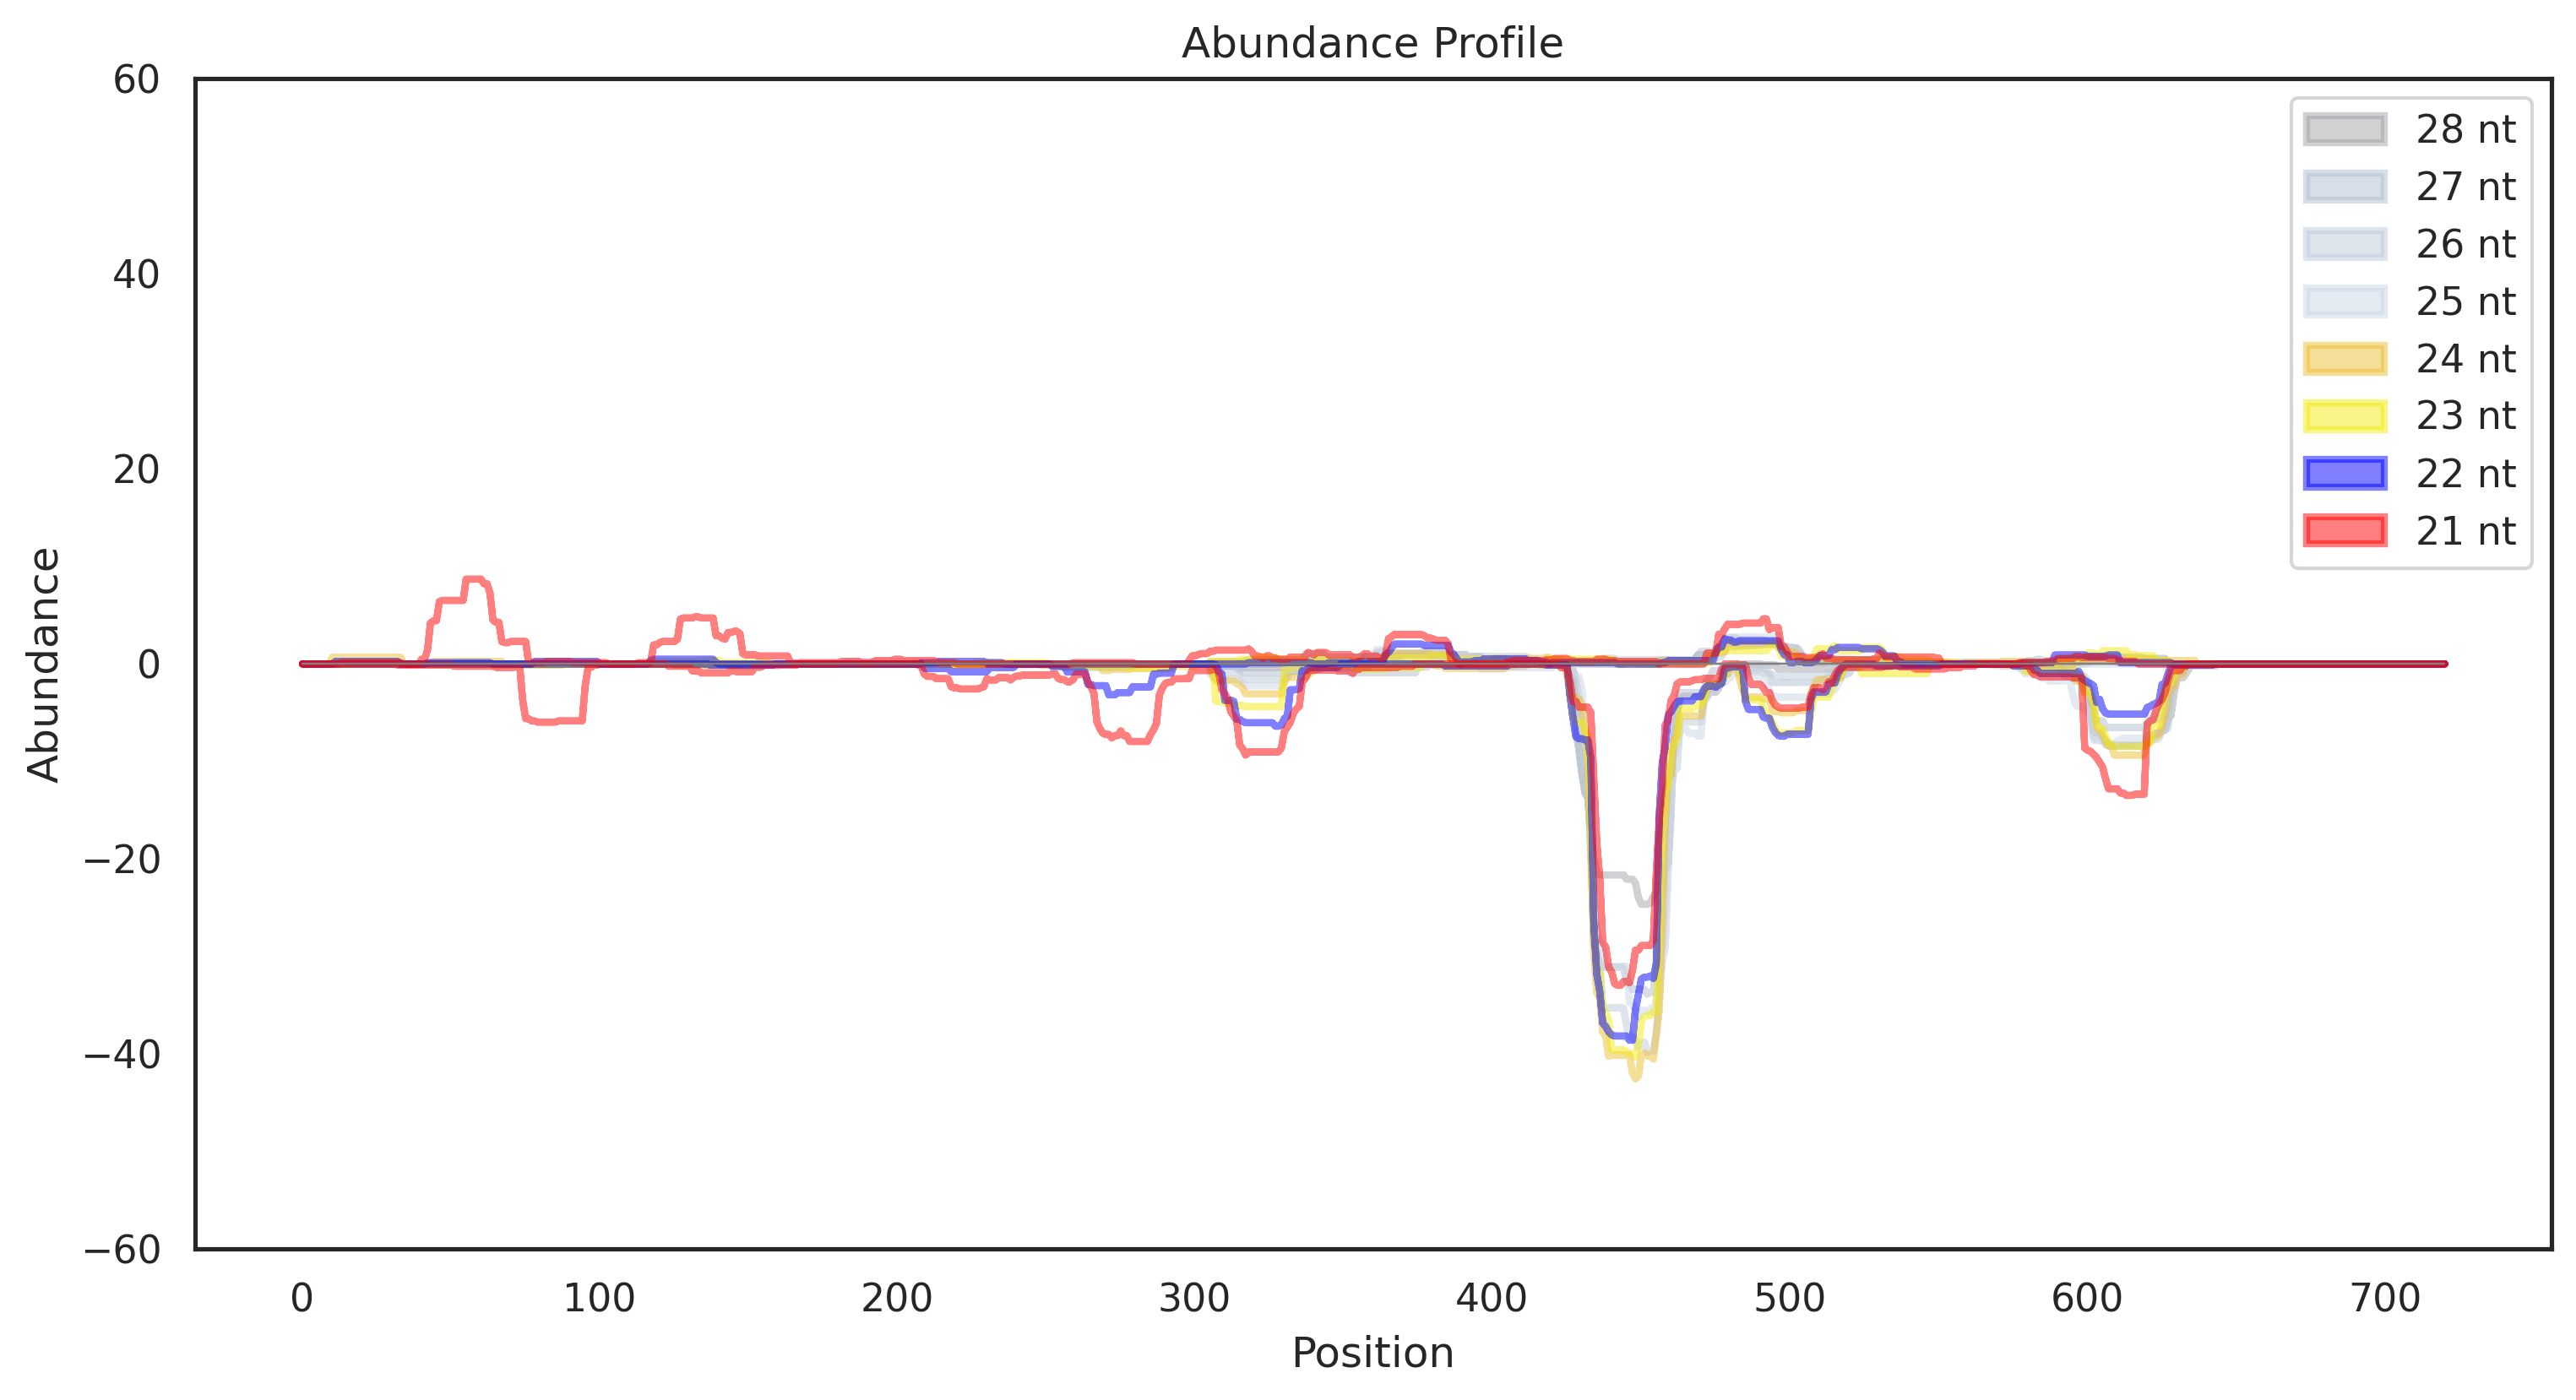

In [50]:
align_plot("brosnan_et_al/figures/fig_S9A/Col_vert_eGFP",
             [28,27,26,25,24,23,22,21], 
             "eGFP", ylim_set=(-60,60), se=True, abund=False, save_file="brosnan_et_al/figures/fig_S9A/Col_vert_eGFP.png")


# Fig 6B

## Aligned to eGFP_GUS

In [51]:
! software/scram2 profile \
    -r brosnan_et_al/ref/eGFP_GUS.fa \
    -1 brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_1.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_2.fq.gz,brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_3.fq.gz \
    -l 18,19,20,21,22,23,24,25,26,27,28 \
    -o brosnan_et_al/figures/fig_6B/Col_vert_eGFP_GUS \
    -t fq --noSplit


Loading individual read counts

SCRAM is attempting to load read files in FASTQ format
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_3.fq.gz - 1,507,385 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_2.fq.gz - 1,687,265 reads processed
brosnan_et_al/reads/234_col_dsGFP-GUS_vert_GFP_input/Col_dsGFP-GUS_vert_GFP_input_1.fq.gz - 2,836,793 reads processed

Loading reference
No. of reference sequences:  1
Combined length of reference sequences: 501 nt

Aligning 18 nt reads

Aligning 19 nt reads

Aligning 20 nt reads

Aligning 21 nt reads

Aligning 22 nt reads

Aligning 23 nt reads

Aligning 24 nt reads

Aligning 25 nt reads

Aligning 26 nt reads

Aligning 27 nt reads

Aligning 28 nt reads

Alignment complete.  Total time taken = 1.954089225s



Empty or broken alignment file - skipping


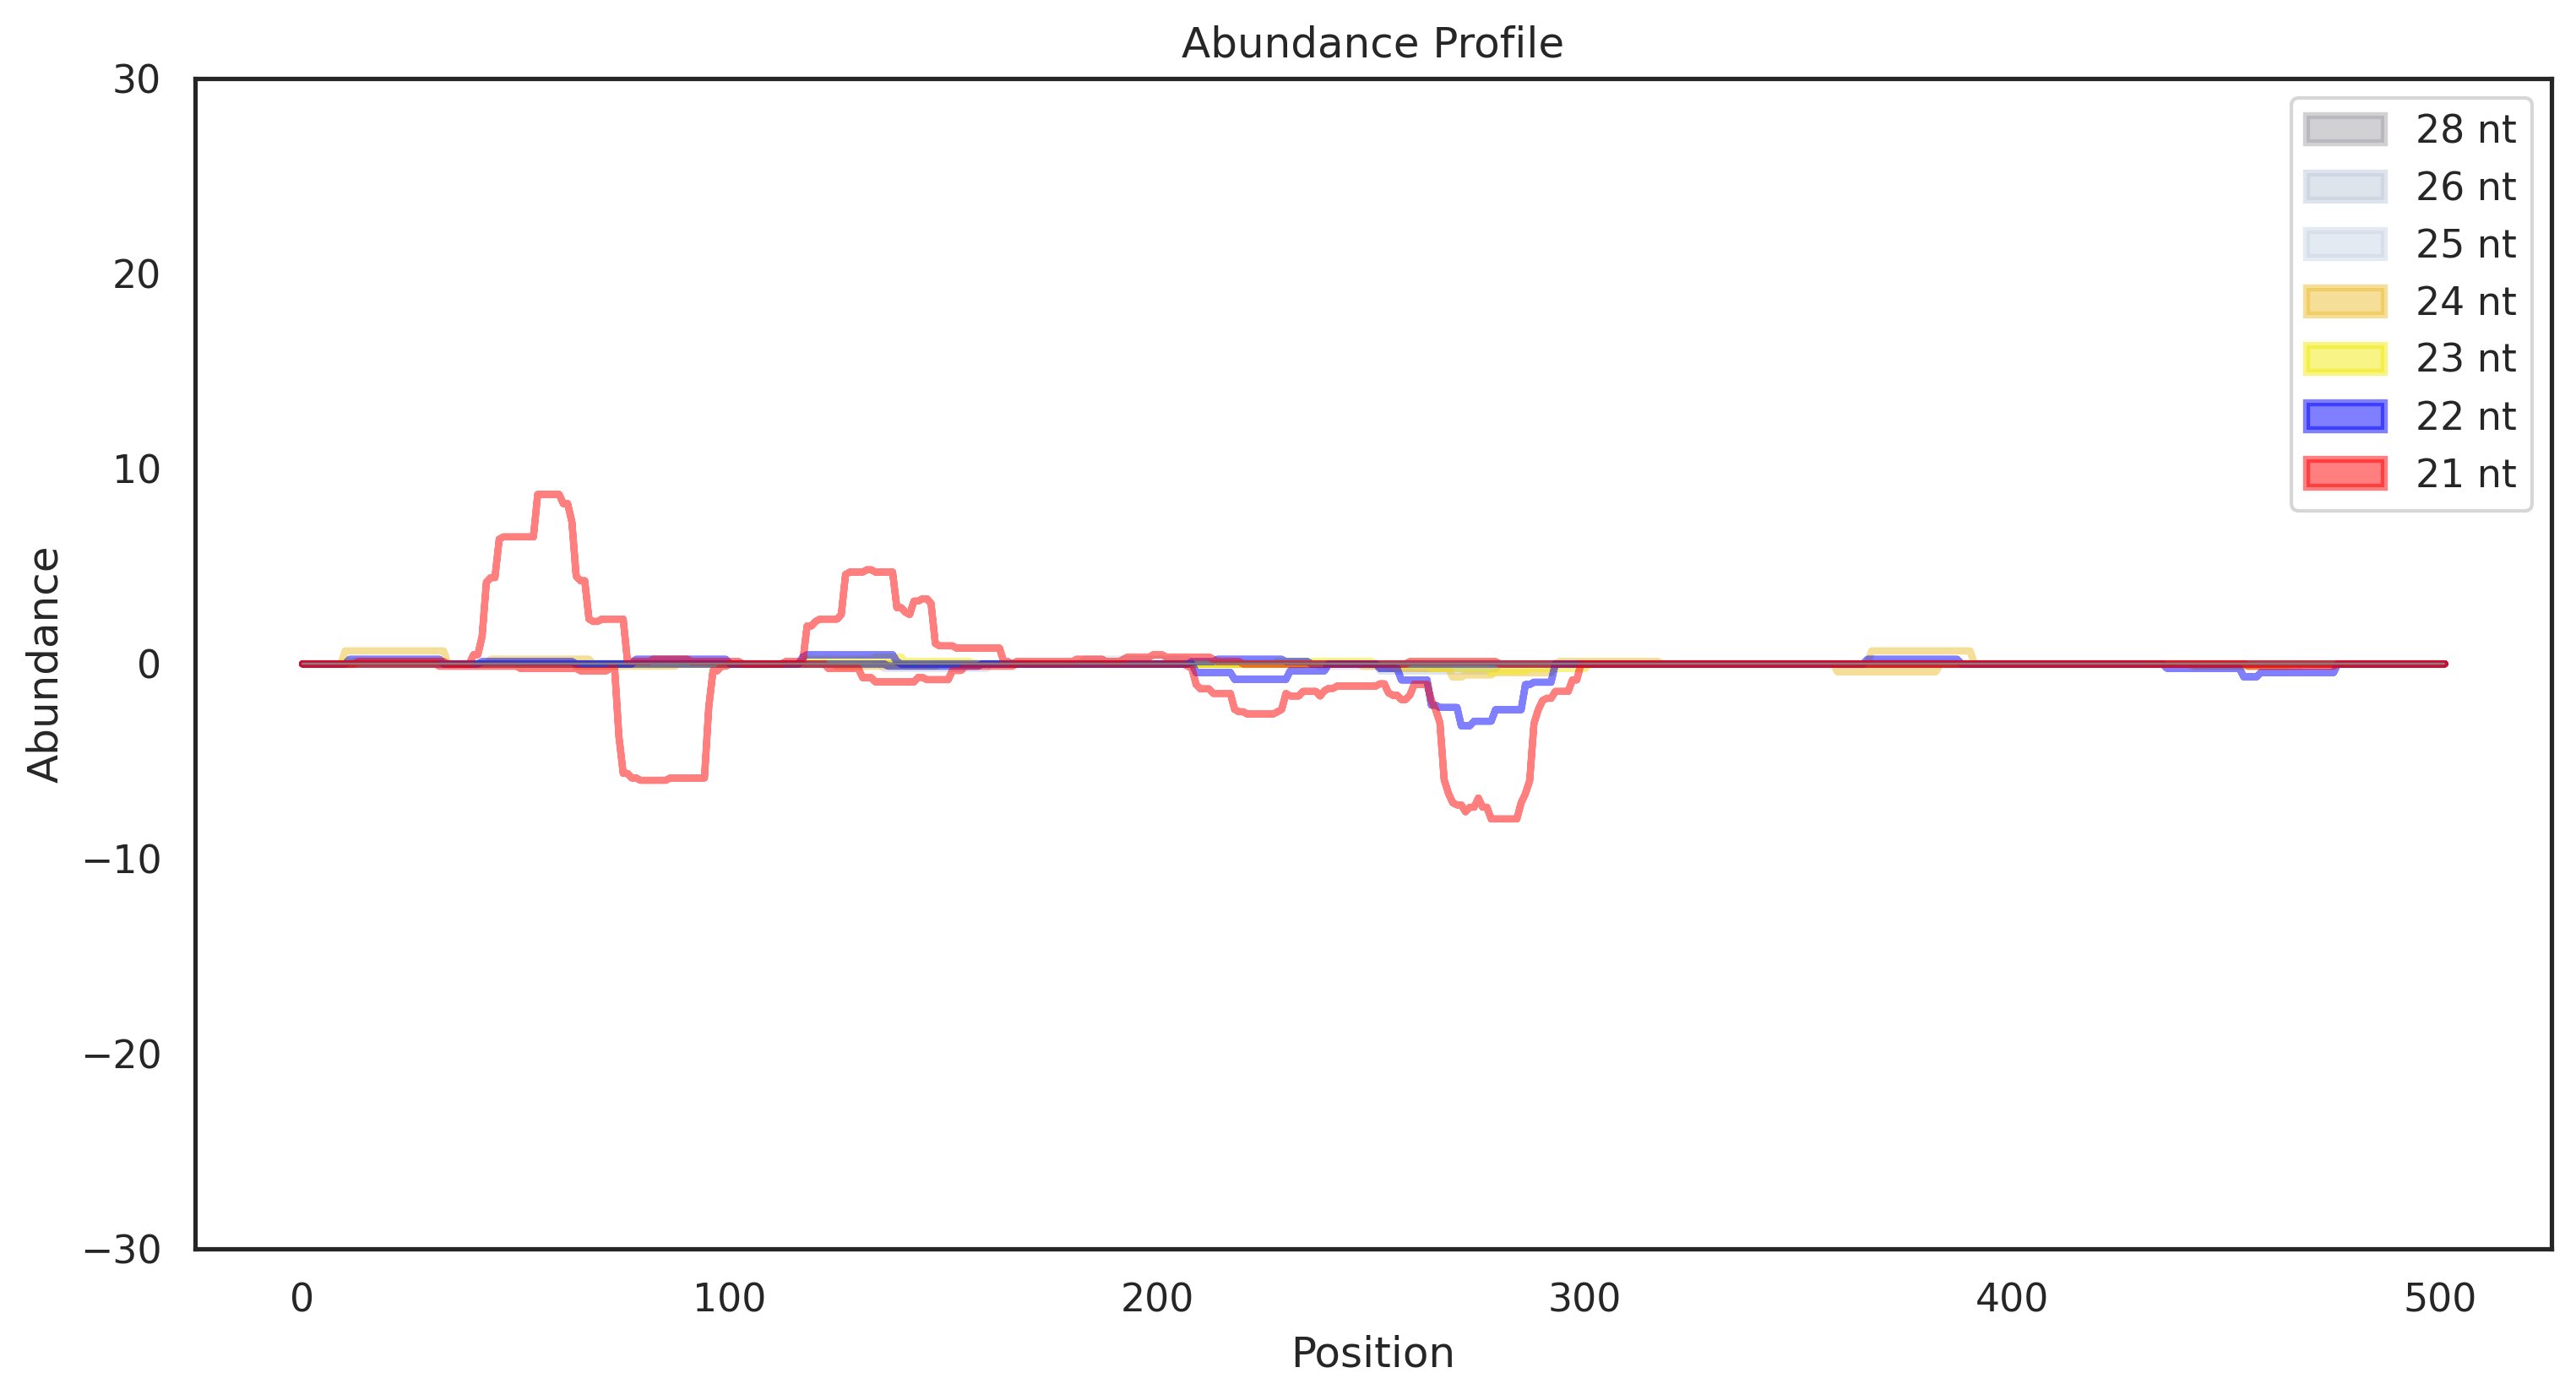

In [52]:
align_plot("brosnan_et_al/figures/fig_6B/Col_vert_eGFP_GUS",
             [28,27,26,25,24,23,22,21], 
             "eGFP_GUS",ylim_set=(-30,30), abund=False, save_file = "brosnan_et_al/figures/fig_6B/Col_vert_eGFP_GUS.png")

# Read files for NCBI upload

## Samples

In [66]:
import glob
file_names = glob.glob("brosnan_et_al/reads/**/*.gz")
count=0
for i in sorted(file_names):
    if count%3==0:
        print(i.split("/")[-1].rsplit("_",1)[0])
    count+=1

234_dsGFP-GUS_vert_GFP_input
Col_dsGFP-GUS_vert_GFP_input
234_dsGFP_bot_GFP_input
234_dsGFP_bot_GFP_trapr
col_dsGFP_bot_GFP_input
col_dsGFP_bot_GFP_trapr
invitro_dsGFP_bot_GFP_input
invitro_dsGFP_bot_GFP_trapr
invitro_neg_GFP_bot_input
invitro_neg_GFP_bot_trapr


## Read files

In [67]:
import glob
file_names = glob.glob("brosnan_et_al/reads/**/*.gz")

for i in sorted(file_names):
    print(i.split("/")[-1])

234_dsGFP-GUS_vert_GFP_input_1.fq.gz
234_dsGFP-GUS_vert_GFP_input_2.fq.gz
234_dsGFP-GUS_vert_GFP_input_3.fq.gz
Col_dsGFP-GUS_vert_GFP_input_1.fq.gz
Col_dsGFP-GUS_vert_GFP_input_2.fq.gz
Col_dsGFP-GUS_vert_GFP_input_3.fq.gz
234_dsGFP_bot_GFP_input_1.fq.gz
234_dsGFP_bot_GFP_input_2.fq.gz
234_dsGFP_bot_GFP_input_3.fq.gz
234_dsGFP_bot_GFP_trapr_1.fq.gz
234_dsGFP_bot_GFP_trapr_2.fq.gz
234_dsGFP_bot_GFP_trapr_3.fq.gz
col_dsGFP_bot_GFP_input_1.fq.gz
col_dsGFP_bot_GFP_input_2.fq.gz
col_dsGFP_bot_GFP_input_3.fq.gz
col_dsGFP_bot_GFP_trapr_1.fq.gz
col_dsGFP_bot_GFP_trapr_2.fq.gz
col_dsGFP_bot_GFP_trapr_3.fq.gz
invitro_dsGFP_bot_GFP_input_1.fq.gz
invitro_dsGFP_bot_GFP_input_2.fq.gz
invitro_dsGFP_bot_GFP_input_3.fq.gz
invitro_dsGFP_bot_GFP_trapr_1.fq.gz
invitro_dsGFP_bot_GFP_trapr_2.fq.gz
invitro_dsGFP_bot_GFP_trapr_3.fq.gz
invitro_neg_GFP_bot_input_1.fq.gz
invitro_neg_GFP_bot_input_2.fq.gz
invitro_neg_GFP_bot_trapr_1.fq.gz
invitro_neg_GFP_bot_trapr_2.fq.gz
